<a href="https://www.kaggle.com/code/catalystcooperative/01-pudl-data-access?scriptVersionId=150421890" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Purpose of this Notebook

Provide an introduction to working with the data integrated into Catalyst Cooperative's Public Utility Data Liberation (PUDL) database, from various public data sources. We will use PUDL to explore Companche 3's brief and checkered existence, in terms of its carbon emissions, electricity generation, costs, and reliability.

By the end of this notebook, you will be able to:
- use PUDL to access FERC, EIA, and EPA data about a specific power plant
- use that data, as well as the [PUDL data dictionary](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html) to build a coherent narrative

# Comanche 3: A Snapshot of US Energy Transition

## Background
- In 2009 Xcel Energy Colorado (also known as Public Service Company of Colorado or PSCo) spent about 1.3 billion dollars building one of the last US coal plants in Pueblo, Colorado.
- The plant was bitterly contested from the beginning, with clean energy activists decrying the 60 years of future GHG emissions that the plant was to lock in, and declining economically accessible coal reserves in the Powder River Basin of Wyoming.
- After a decade of [high operating costs, ongoing maintenance issues](https://coloradosun.com/2021/03/03/comanche-3-cost-overruns-shutdown-electricity/), political pressure, and rapid renewable price declines, Xcel finally [agreed to shut the plant down 40 years early](https://coloradosun.com/2022/04/26/comanche-plant-xcel-coal/)


## Datasets we will use
- [FERC Form 1](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/ferc1.html) (the Annual Report of Major Electric Utilities) will provide non-fuel operating costs as well as ongoing capital expenses.
- [EIA Form 860](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/eia860.html) (the Annual Electric Generator Report) will provide detailed physical attributes of individual generators, as well as their ownership shares.
- [EIA Form 923](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/eia923.html) (the Power Plant Operations Report) will provide information about fuel consumption and costs, net electricity generation, and generator thermal efficiency.
- [EPA's Continuous Emissions Monitoring System](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/epacems.html) will provide hourly power plant emissions, fuel consumption, and power output.


# Additional PUDL Project Resources
Links to more information on Catalyst Cooperative's Public Utility Data Liberation (PUDL) Project.

## PUDL Data Dictionaries:
* [Table and column level metadata for the PUDL database](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html)
* [Table level metadata for 2020 and earlier raw FERC Form 1 DBF data](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/ferc1_db.html) (**Note:** the raw FERC Form 1 data is very difficult to work with. Check whether the table you want to work with has been cleaned up and imported into PUDL)
* All XBRL-derived FERC forms (2021 and later) have extensive metadata published alongside their databases in the nightly builds (see below). These take the form of a JSON version of their XBRL taxonomy, and a [datapackage descriptor](https://specs.frictionlessdata.io/data-package/) that annotates the XBRL-derived SQLite DB.

## Nightly Build Outputs:
We attempt to rebuild all of our data products each night, based on the code in [the development branch](https://github.com/catalyst-cooperative/pudl/tree/dev) of the [main PUDL repository on GitHub](https://github.com/catalyst-cooperative/pudl). 

The most recent successful build outputs can be downloaded directly from:
* [The PUDL Project in the AWS Open Data Registry](https://registry.opendata.aws/catalyst-cooperative-pudl/)
* [Direct AWS S3 download links](https://catalystcoop-pudl.readthedocs.io/en/latest/data_access.html#access-nightly-builds) on our data access page.
* The [PUDL Project Dataset](https://www.kaggle.com/datasets/catalystcooperative/pudl-project) on Kaggle updates automatically whenever the nightly builds succeed.

## Datasette: https://data.catalyst.coop
Successful nightly build outputs are also deployed using [Simon Willison](https://simonwillison.net/)'s excellent [Datasette](https://datasette.io/) tool. It provides a simple web interface for browsing and querying all of the SQLite databases we publish.

## GitHub Discussions
We use [GitHub Discussions](https://github.com/orgs/catalyst-cooperative/discussions) to answer questions about PUDL and provide user support. Let us know if you have issues or find bugs!

# Notebook Setup
Boilerplate setup. You don't have to think hard about this, but if you want to, the comments provide some useful context.

In [1]:
import sys
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

print(f"Python version: {sys.version}")
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlalchemy as sa

print(f"{np.__version__=}")
print(f"{pd.__version__=}")
print(f"{sa.__version__=}")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in sorted(filenames):
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
sns.set()
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16, 10)
matplotlib.rcParams["figure.dpi"] = 150
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 1000)

Python version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
np.__version__='1.24.3'
pd.__version__='2.0.3'
sa.__version__='2.0.20'
/kaggle/input/pudl-project/censusdp1tract.sqlite
/kaggle/input/pudl-project/ferc1.sqlite
/kaggle/input/pudl-project/ferc1_xbrl.sqlite
/kaggle/input/pudl-project/ferc1_xbrl_datapackage.json
/kaggle/input/pudl-project/ferc1_xbrl_taxonomy_metadata.json
/kaggle/input/pudl-project/ferc2.sqlite
/kaggle/input/pudl-project/ferc2_xbrl.sqlite
/kaggle/input/pudl-project/ferc2_xbrl_datapackage.json
/kaggle/input/pudl-project/ferc2_xbrl_taxonomy_metadata.json
/kaggle/input/pudl-project/ferc6.sqlite
/kaggle/input/pudl-project/ferc60.sqlite
/kaggle/input/pudl-project/ferc60_xbrl.sqlite
/kaggle/input/pudl-project/ferc60_xbrl_datapackage.json
/kaggle/input/pudl-project/ferc60_xbrl_taxonomy_metadata.json
/kaggle/input/pudl-project/ferc6_xbrl.sqlite
/kaggle/input/pudl-project/ferc6_xbrl_datapackage.json
/kaggle/input/pudl-project/ferc6_xbrl_

# Reading data from the PUDL SQLite Database
- Most of the PUDL Project data is distributed using SQLite databases.
 - Python, pandas, and many other libraries have built-in support for reading data from SQLite, and it is a file-based database that doesn't require running a database server, which is much simpler for local analysis and data distribution.
- Only one of these databases is meant for general public consumption: `pudl.sqlite`.
- The other SQLite databases pertain to various FERC forms and are unprocessed conversions of FERC's difficult to use original data formats (Visual FoxPro up to 2020, and XBRL starting in 2021). We will not look at these relatively raw inputs in this notebook.
- [SQLAlchemy](https://docs.sqlalchemy.org/en/20/) is Python's general purpose database access library, and is integrated directly with the [pandas](https://pandas.pydata.org/) data analysis library that you may already be familiar with.

## Create a connection engine for the PUDL Database

In [2]:
import pathlib
import sqlalchemy as sa

# Path to the directory that contains all the PUDL data on Kaggle:
pudl_path = pathlib.Path("/kaggle/input/pudl-project")

# Create a connection using SQLAlchemy, we'll pass this to pandas below to read data.
pudl_engine = sa.create_engine(f"sqlite:///{pudl_path}/pudl.sqlite")

## Read EIA plant data from the PUDL SQLite Database
- We'll read the entire [denormalized EIA plants table](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html#denorm-plants-eia) -- "denormalized" just means that it has additional useful information merged in that might be duplicative, but is more convenient for interactive use.
- Power plants are industrial facilities operated by a single utility, but they can have multiple owners, and host multiple generation units.
- The `denorm_plants_eia` table contains only information that pertains to all of the equipment at the plant. like its location, or connections to the natural gas and electricity transmission systems.
- Most of these attributes are relatively stable, but they can change slowly over time, so each plant as one record for each `report_date`.
- There are also several ID columns in this table that will be useful for joining it with other data later.
- The table has more than 50 columns. You can look up short descriptions of what all these columns mean in the [PUDL Data Dictionary](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html)

In [3]:
%%time
plants_eia = pd.read_sql("denorm_plants_eia", pudl_engine).convert_dtypes(convert_floating=False)

# Filter to plants with "comanche" in the name, so we can find the PUDL plant ID
plants_eia.loc[
    plants_eia.plant_name_eia.str.contains("comanche", case=False),
    [
        "plant_id_eia",
        "plant_id_pudl",
        "plant_name_eia",
        "utility_name_eia",
        "city",
        "state",
        "latitude",
        "longitude",
    ]
].drop_duplicates()

CPU times: user 7.33 s, sys: 1.07 s, total: 8.4 s
Wall time: 8.95 s


plant_id_eia  plant_id_pudl  plant_name_eia  \
7460             470            126        Comanche   
50775           6145           2514   Comanche Peak   
50788           6145           2514   Comanche Peak   
67387           8059            127        Comanche   
164570         59656           8376  Comanche Solar   
164575         59656           8376  Comanche Solar   

                       utility_name_eia       city state   latitude  longitude  
7460      Public Service Co of Colorado     Pueblo    CO  38.208100 -104.57470  
50775   Luminant Generation Company LLC  Glen Rose    TX  32.298365  -97.78552  
50788              TXU Generation Co LP  Glen Rose    TX  32.298365  -97.78552  
67387     Public Service Co of Oklahoma     Lawton    OK  34.543100  -98.32440  
164570                   Novatus Energy     Pueblo    CO  38.205278 -104.56670  
164575                     Comanche LLC     Pueblo    CO  38.205278 -104.56670

## Reading FERC plant data from the PUDL SQLite DB
* The Federal Energy Regulatory Commission (FERC) also reports data about power plants in their [Form 1 - Annual Report of Major Electric Utilities](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/ferc1.html).
* FERC Form 1 focuses primarily on electric utility finances, rather than operations.
* The [Large Steam Plants](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html) table provides particularly detailed capital expenses and non-fuel O&M costs.
* Unfortunately, these detailed costs are often not attributed to individual generators.
* In the case of Comanche, the costs and other data for all 3 units are lumped together at the plant level, obscuring the impact of Comanche 3.

In [4]:
%%time
plants_ferc1 = pd.read_sql("denorm_plants_steam_ferc1", pudl_engine).convert_dtypes(convert_floating=False)
plants_ferc1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31879 entries, 0 to 31878
Data columns (total 55 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   report_year                             31879 non-null  Int64  
 1   utility_id_ferc1                        31879 non-null  Int64  
 2   utility_id_pudl                         31879 non-null  Int64  
 3   utility_name_ferc1                      31879 non-null  string 
 4   plant_id_pudl                           31879 non-null  Int64  
 5   plant_id_ferc1                          31879 non-null  Int64  
 6   plant_name_ferc1                        31879 non-null  string 
 7   asset_retirement_cost                   9453 non-null   Int64  
 8   avg_num_employees                       18624 non-null  Int64  
 9   capacity_factor                         29486 non-null  float64
 10  capacity_mw                             31879 non-null  fl

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1079: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [5]:
comanche_ferc1 = (
    plants_ferc1.loc[
        plants_ferc1["plant_id_pudl"] == 126,
        [
            "report_year",
            "plant_id_ferc1",
            "plant_name_ferc1",
            "plant_id_pudl",
            "capacity_mw",
            "net_generation_mwh",
            "capacity_factor",
            "capex_annual_addition",  # Total new capital additions for the year. Does not account for retirements / depreciation.
            "capex_annual_per_mw",    # Annual additions divided by plant capacity.
            "capex_annual_per_mwh",   # Annual additions divided by net generation for the year.
            "opex_total_nonfuel",     # Total non-fuel operating expensees. (EIA provides better fuel costs)
            "opex_per_mwh",           # Total operating expenses (including fuel) per MWh of net generation.
            "opex_nonfuel_per_mwh",   # Total non-fuel operating expenses per MWh of net generation.
            "opex_fuel_per_mwh",      # Total fuel-based operating expenses per MWh of net generation.
        ]
    ]
    .assign(report_date=lambda x: pd.to_datetime(x.report_year.astype("string")))
    .set_index("report_date")
    .assign(rolling5yr_capex_per_mwh=lambda x: x.capex_annual_per_mwh.rolling(window=5).mean())
    .reset_index()
)
comanche_ferc1

report_date  report_year  plant_id_ferc1 plant_name_ferc1  plant_id_pudl  \
0   1994-01-01         1994             517         comanche            126   
1   1995-01-01         1995             517         comanche            126   
2   1996-01-01         1996             517         comanche            126   
3   1997-01-01         1997             517         comanche            126   
4   1998-01-01         1998             517         comanche            126   
5   1999-01-01         1999             517         comanche            126   
6   2000-01-01         2000             517         comanche            126   
7   2001-01-01         2001             517         comanche            126   
8   2002-01-01         2002             517         comanche            126   
9   2003-01-01         2003             517         comanche            126   
10  2004-01-01         2004             517         comanche            126   
11  2005-01-01         2005             517         comanche            126   
12  2006-01-01         2006             517         comanche            126   
13  2007-01-01         2007             517         comanche            126   
14  2008-01-01         2008             517         comanche            126   
15  2009-01-01         2009             517         comanche            126   
16  2010-01-01         2010             517         comanche            126   
17  2011-01-01         2011             517         comanche            126   
18  2012-01-01         2012             517         comanche            126   
19  2013-01-01         2013             517         comanche            126   
20  2014-01-01         2014             517         comanche            126   
21  2015-01-01         2015             517         comanche            126   
22  2016-01-01         2016             517         comanche            126   
23  2017-01-01         2017             517         comanche            126   
24  2018-01-01         2018             517         comanche            126   
25  2019-01-01         2019             517         comanche            126   
26  2020-01-01         2020             517         comanche            126   
27  2021-01-01         2021             517         comanche            126   
28  2022-01-01         2022             517         comanche            126   

    capacity_mw  net_generation_mwh  capacity_factor  capex_annual_addition  \
0         700.0         3253066.000         0.530507                   <NA>   
1         700.0         4023033.000         0.656072              -11430522   
2         700.0         4319083.000         0.704351                3084980   
3         700.0         4424635.000         0.721565                1236211   
4         700.0         4437115.000         0.723600                1559238   
5         700.0         4563838.000         0.744266                 839874   
6         700.0         4223848.000         0.688821               18632482   
7         700.0         4431900.000         0.722750                6769892   
8         700.0         4697172.000         0.766010                1950727   
9         700.0         4864064.000         0.793226                6861609   
10        700.0         4301827.000         0.701537               13251640   
11        700.0         4292543.000         0.700023                4195309   
12        700.0         4877932.000         0.795488                 545492   
13        700.0         4450973.000         0.725860                9707938   
14        700.0         4378101.000         0.713976              128710666   
15        778.5         4705019.000         0.689920               31917284   
16       1284.0         5959070.000         0.529797              956244773   
17       1635.3         6169782.000         0.430693               17541647   
18       1635.3         7421325.000         0.518060               54997766   
19       1635.3         7239127.000         0.505341

## Cost Increases and Downtime

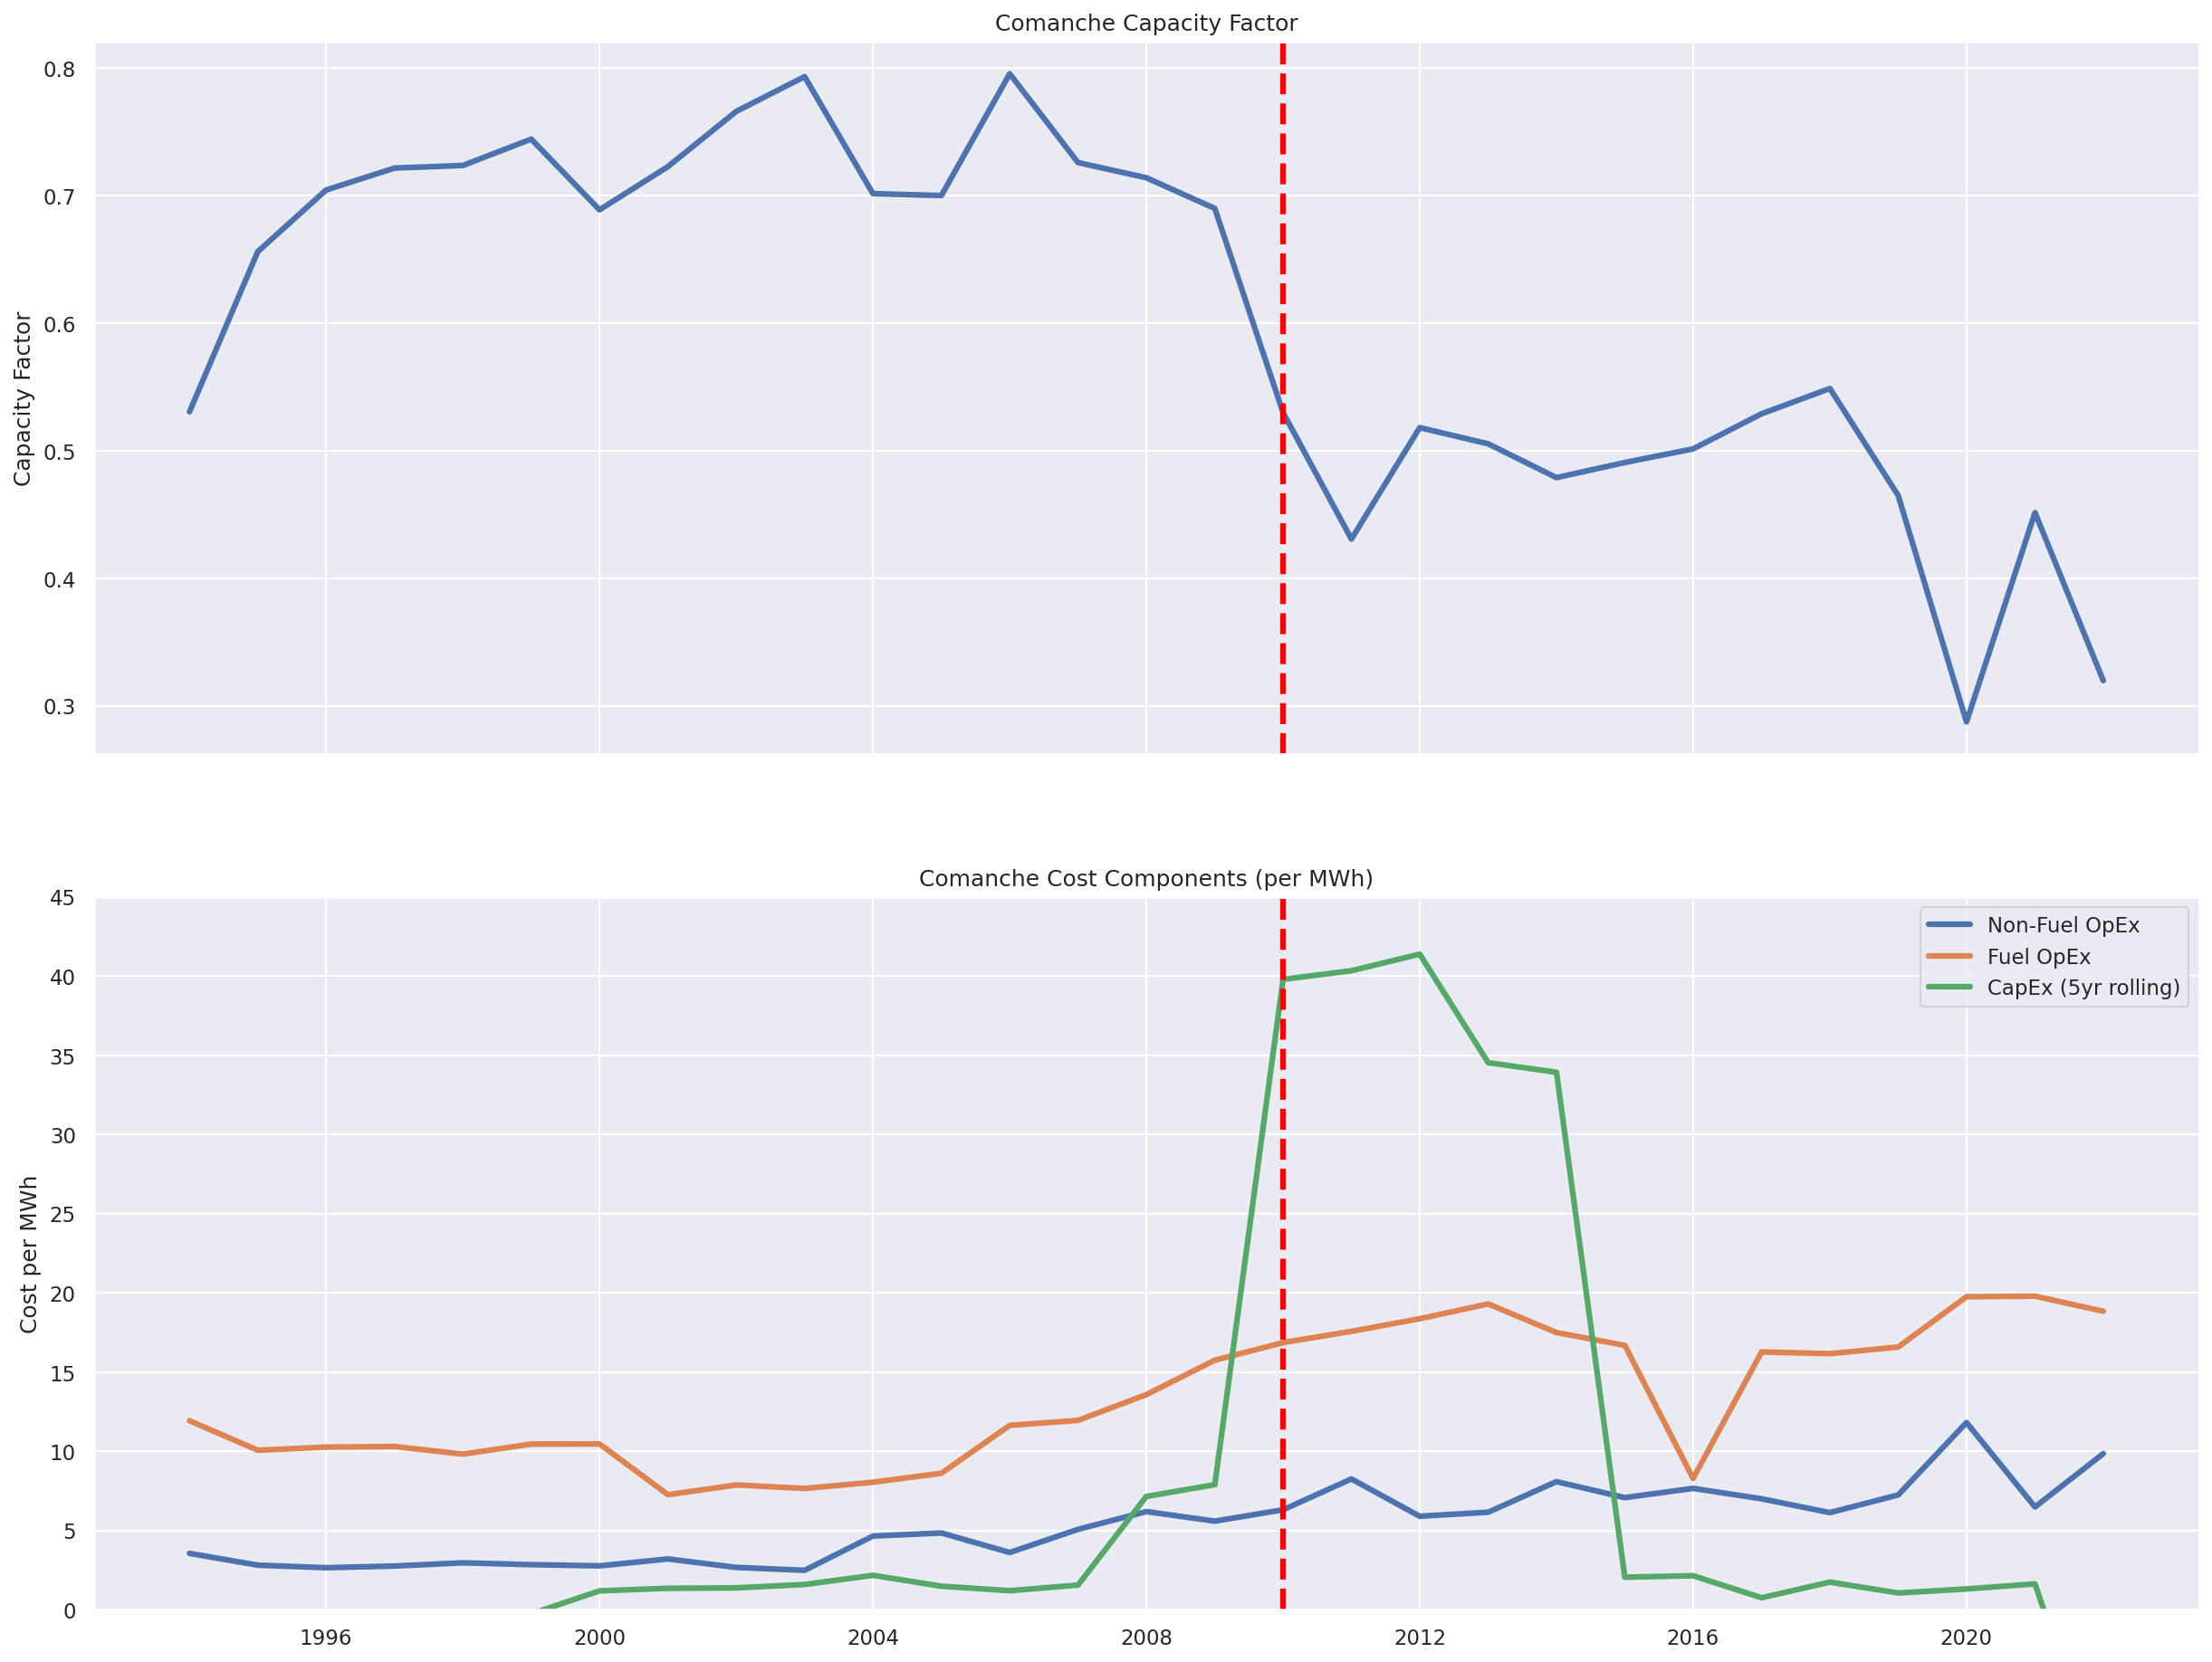

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20,15))
kwargs = {"lw": 3}

axs[0].plot(
    comanche_ferc1.report_date,
    comanche_ferc1.capacity_factor,
    **kwargs,
)
axs[0].set_ylabel("Capacity Factor")
axs[0].axvline(x=pd.Timestamp("2010-01-01"), color="red", linestyle="--", lw=3)
axs[0].set_title("Comanche Capacity Factor")

axs[1].plot(
    comanche_ferc1.report_date,
    comanche_ferc1.opex_nonfuel_per_mwh,
    label="Non-Fuel OpEx",
    **kwargs,
)
axs[1].plot(
    comanche_ferc1.report_date,
    comanche_ferc1.opex_fuel_per_mwh,
    label="Fuel OpEx",
    **kwargs,
)
axs[1].plot(
    comanche_ferc1.report_date,
    comanche_ferc1.rolling5yr_capex_per_mwh,
    label="CapEx (5yr rolling)",
    **kwargs,
)
axs[1].set_ylabel("Cost per MWh")
axs[1].set_ylim(0, 45)
axs[1].set_title("Comanche Cost Components (per MWh)")
axs[1].axvline(x=pd.Timestamp("2010-01-01"), color="red", linestyle="--", lw=3)
plt.legend()
plt.show();

## Getting generator-level data from EIA

The above graphs, using FERC data, show performance for the whole Comanche plant - clearly something happened in 2010. In this case, we know a priori that a new generator was added - let's dig into that a little bit.

# Pre-calculated EIA Generator Statistics
* We have pre-calculated a number of useful generator statistics based on the EIA 860 and 923 data in the [MCOE Generators Tables](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html#mcoe-generators-monthly)
* At first glance you might think these would be easy to calculate, but because of the different reporting requirements that apply to different sizes and types of power plants, that's unfortunately not true.
* These statistics are available both on a monthly and yearly basis.

In [7]:
%%time
comanche_mcoe = (
    pd.read_sql("SELECT * FROM mcoe_generators_monthly WHERE plant_id_eia=470", pudl_engine)
    .convert_dtypes(convert_floating=False)
    .sort_values(["report_date", "plant_id_eia", "generator_id"])
)
display(comanche_mcoe.info())
display(comanche_mcoe.sample(10))

<class 'pandas.core.frame.DataFrame'>
Index: 692 entries, 517 to 691
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   plant_id_eia                       692 non-null    Int64  
 1   generator_id                       692 non-null    string 
 2   report_date                        692 non-null    string 
 3   unit_id_pudl                       517 non-null    Int64  
 4   plant_id_pudl                      692 non-null    Int64  
 5   plant_name_eia                     692 non-null    string 
 6   utility_id_eia                     692 non-null    Int64  
 7   utility_id_pudl                    692 non-null    Int64  
 8   utility_name_eia                   692 non-null    string 
 9   technology_description             692 non-null    string 
 10  energy_source_code_1               692 non-null    string 
 11  prime_mover_code                   692 non-null    string 
 1

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1079: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


None

plant_id_eia generator_id report_date  unit_id_pudl  plant_id_pudl  \
442           470            3  2016-10-01             3            126   
353           470            2  2022-06-01             2            126   
550           470            1  2003-10-01          <NA>            126   
534           470            1  2002-06-01          <NA>            126   
562           470            1  2004-10-01          <NA>            126   
541           470            1  2003-01-01          <NA>            126   
464           470            3  2018-08-01             3            126   
532           470            1  2002-04-01          <NA>            126   
296           470            2  2017-09-01             2            126   
30            470            1  2010-07-01             1            126   

    plant_name_eia  utility_id_eia  utility_id_pudl  \
442       Comanche           15466              272   
353       Comanche           15466              272   
550       Comanche           15466              272   
534       Comanche           15466              272   
562       Comanche           15466              272   
541       Comanche           15466              272   
464       Comanche           15466              272   
532       Comanche           15466              272   
296       Comanche           15466              272   
30        Comanche           15466              272   

                  utility_name_eia   technology_description  \
442  Public Service Co of Colorado  Conventional Steam Coal   
353  Public Service Co of Colorado  Conventional Steam Coal   
550  Public Service Co of Colorado  Conventional Steam Coal   
534  Public Service Co of Colorado  Conventional Steam Coal   
562  Public Service Co of Colorado  Conventional Steam Coal   
541  Public Service Co of Colorado  Conventional Steam Coal   
464  Public Service Co of Colorado  Conventional Steam Coal   
532  Public Service Co of Colorado  Conventional Steam Coal   
296  Public Service Co of Colorado  Conventional Steam Coal   
30   Public Service Co of Colorado  Conventional Steam Coal   

    energy_source_code_1 prime_mover_code generator_operating_date  \
442                  SUB               ST               2010-07-01   
353                  SUB               ST               1975-06-01   
550                  BIT               ST               1973-06-01   
534                  BIT               ST               1973-06-01   
562                  SUB               ST               1973-06-01   
541                  BIT               ST               1973-06-01   
464                  SUB               ST               2010-07-01   
532                  BIT               ST               1973-06-01   
296                  SUB               ST               1975-06-01   
30                   SUB               ST               1973-06-01   

    generator_retirement_date operational_status  capacity_mw  \
442                      <NA>           existing        856.8   
353                      <NA>           existing        396.0   
550                      <NA>           existing        382.5   
534                      <NA>           existing        350.0   
562                      <NA>           existing        382.5   
541                      <NA>           existing        382.5   
464                      <NA>           existing        856.8   
532                      <NA>           existing        350.0   
296                      <NA>           existing        396.0   
30                       <NA>           existing        382.5   

    fuel_type_code_pudl planned_generator_retirement_date  capacity_factor  \
442                coal                              <NA>         0.768319   
353                coal                        2025-12-01         0.584947   
550                coal                              <NA>         0.747357   
534                coal                              <NA>         0.841226   
56

CPU times: user 665 ms, sys: 945 ms, total: 1.61 s
Wall time: 13.9 s


## Monthly Net Generation

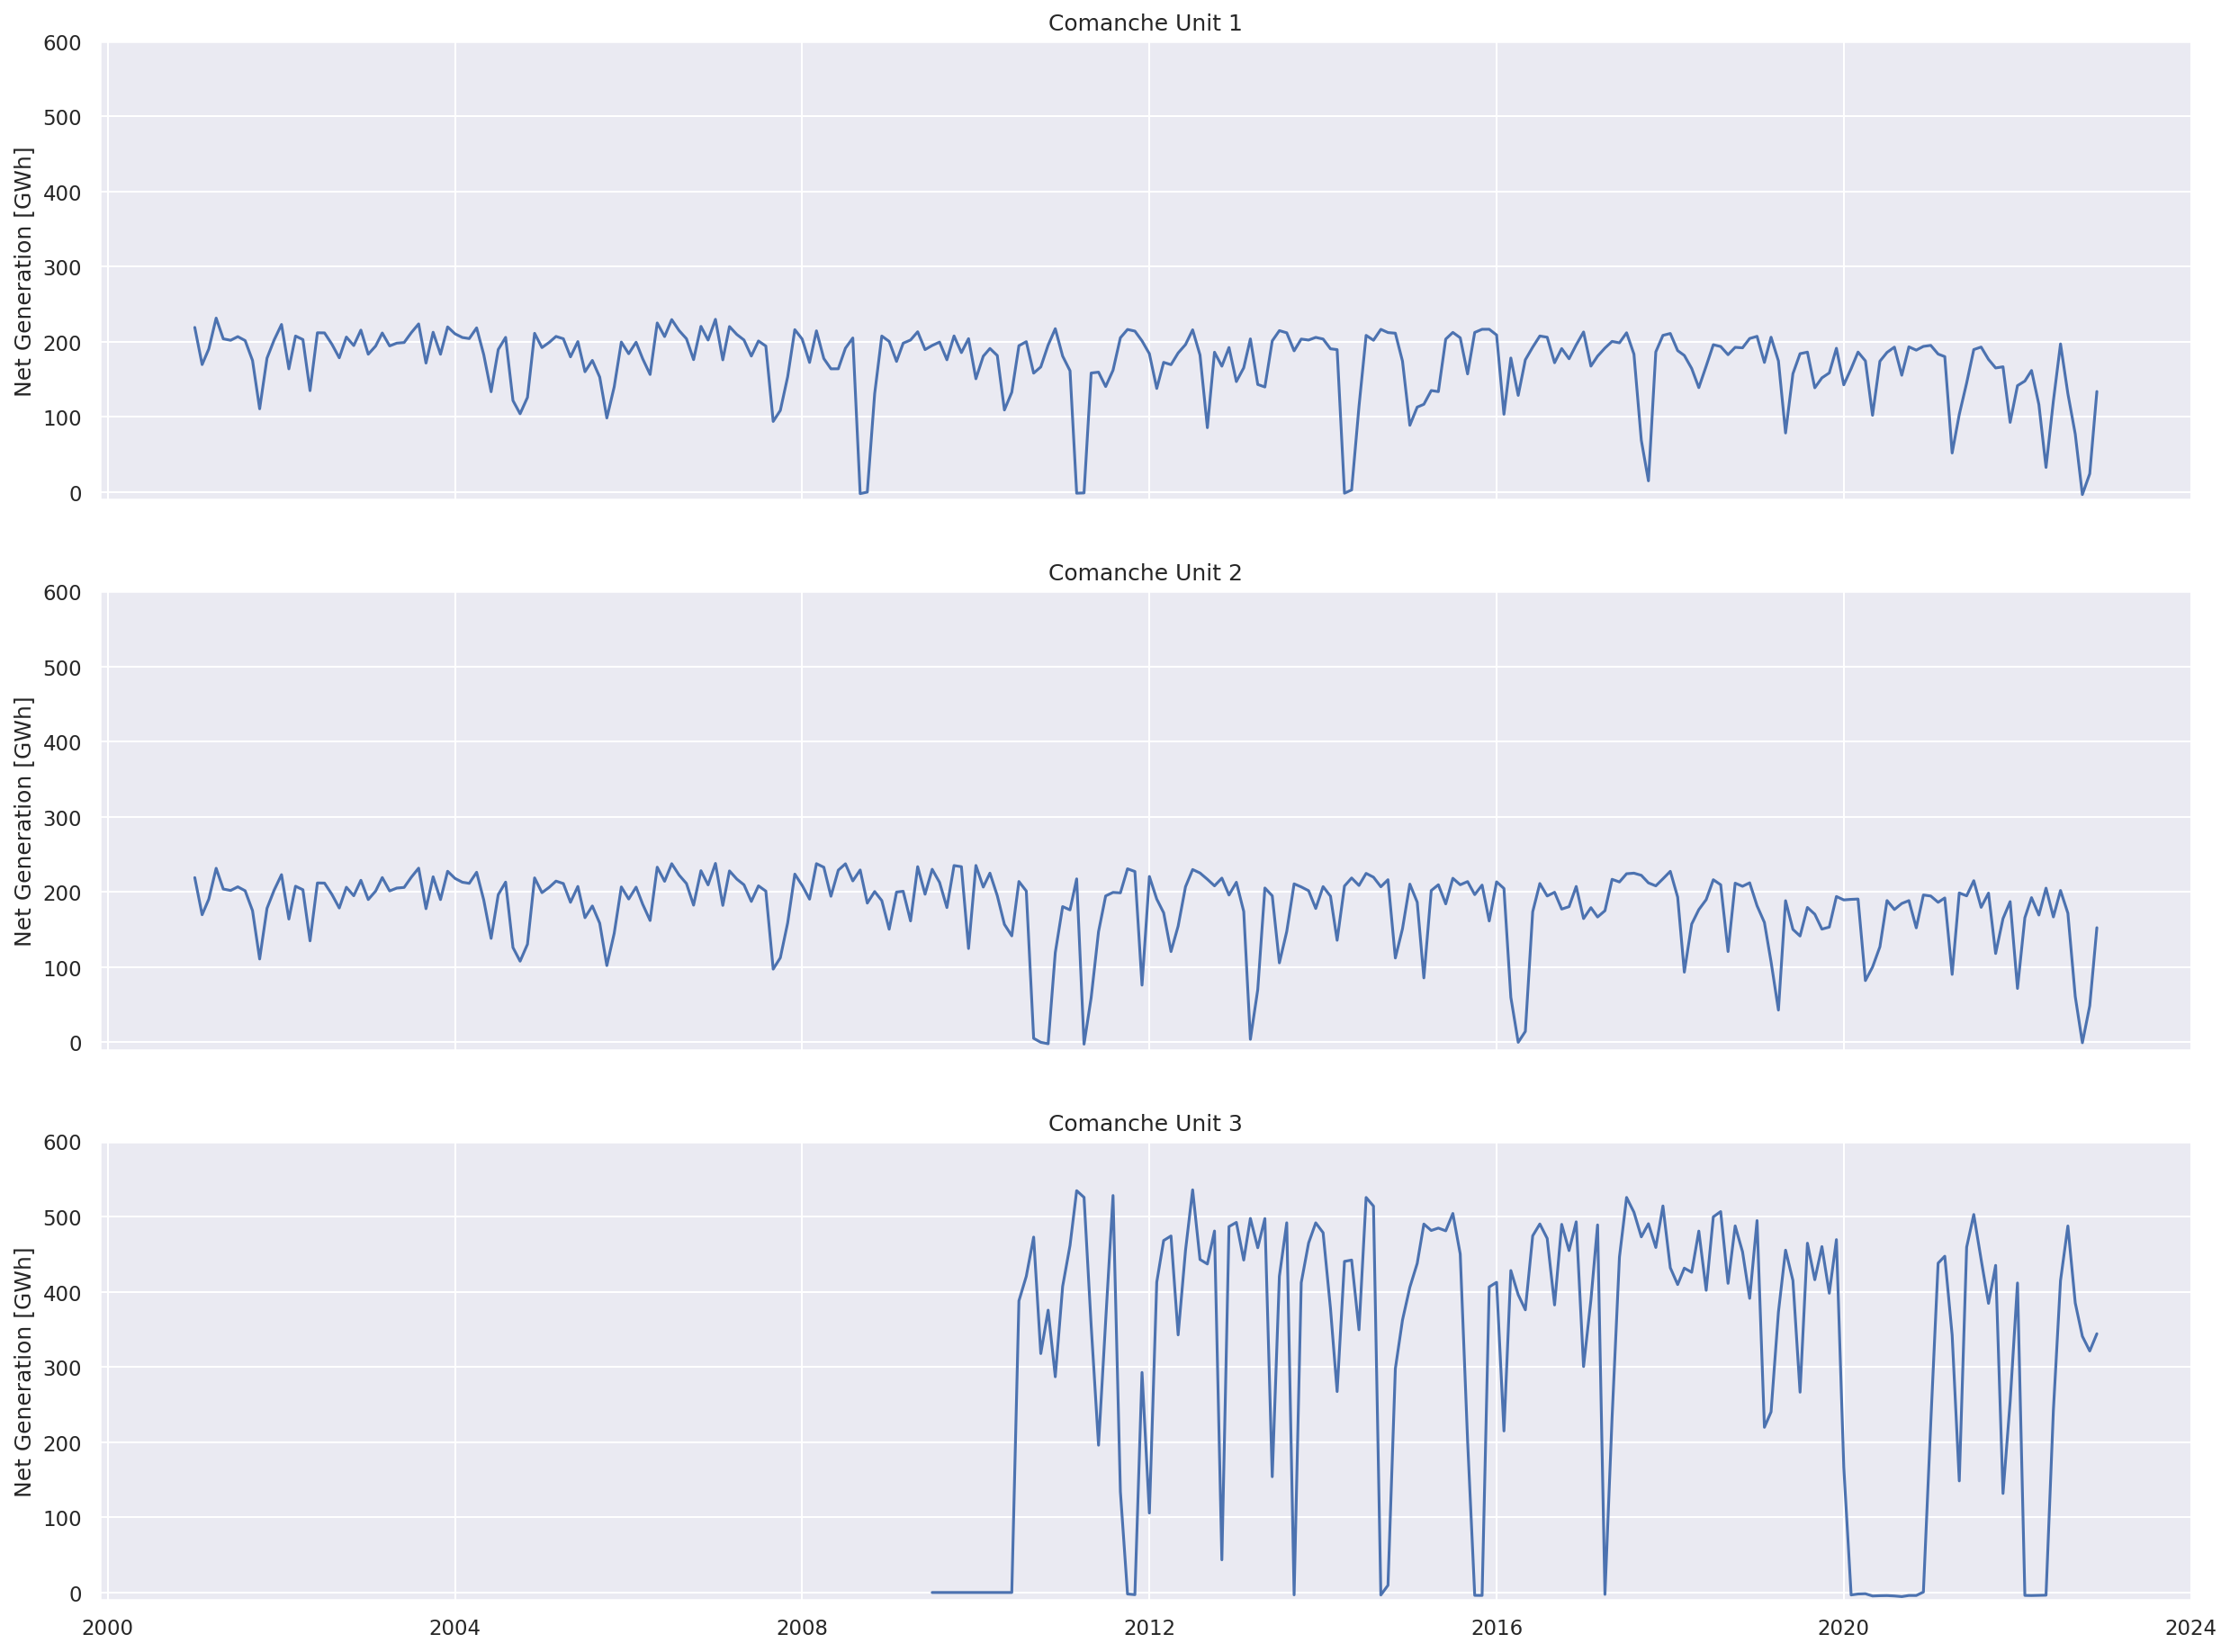

In [8]:
gen_ids = ["1", "2", "3"]
fig, axs = plt.subplots(nrows=len(gen_ids), ncols=1, sharex=True, figsize=(20,15))
for n, gen_id in enumerate(gen_ids):
    axs[n].plot(
        pd.to_datetime(comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "report_date"]),
        comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "net_generation_mwh"] / 1000.0,
    )
    axs[n].set_ylim(-10, 600)
    axs[n].set_title(f"Comanche Unit {gen_id}")
    axs[n].set_ylabel("Net Generation [GWh]")
plt.show();

## Monthly Fuel Costs per MWh
- Overall coal prices have been pretty stable.
- Unit 1 appears to have slightly higher fuel costs per MWh
- Spikes in per-MWh fuel costs are due to the fact that monthly fuel costs are based on fuel deliveries, which may still take place even if the plant is not operating.

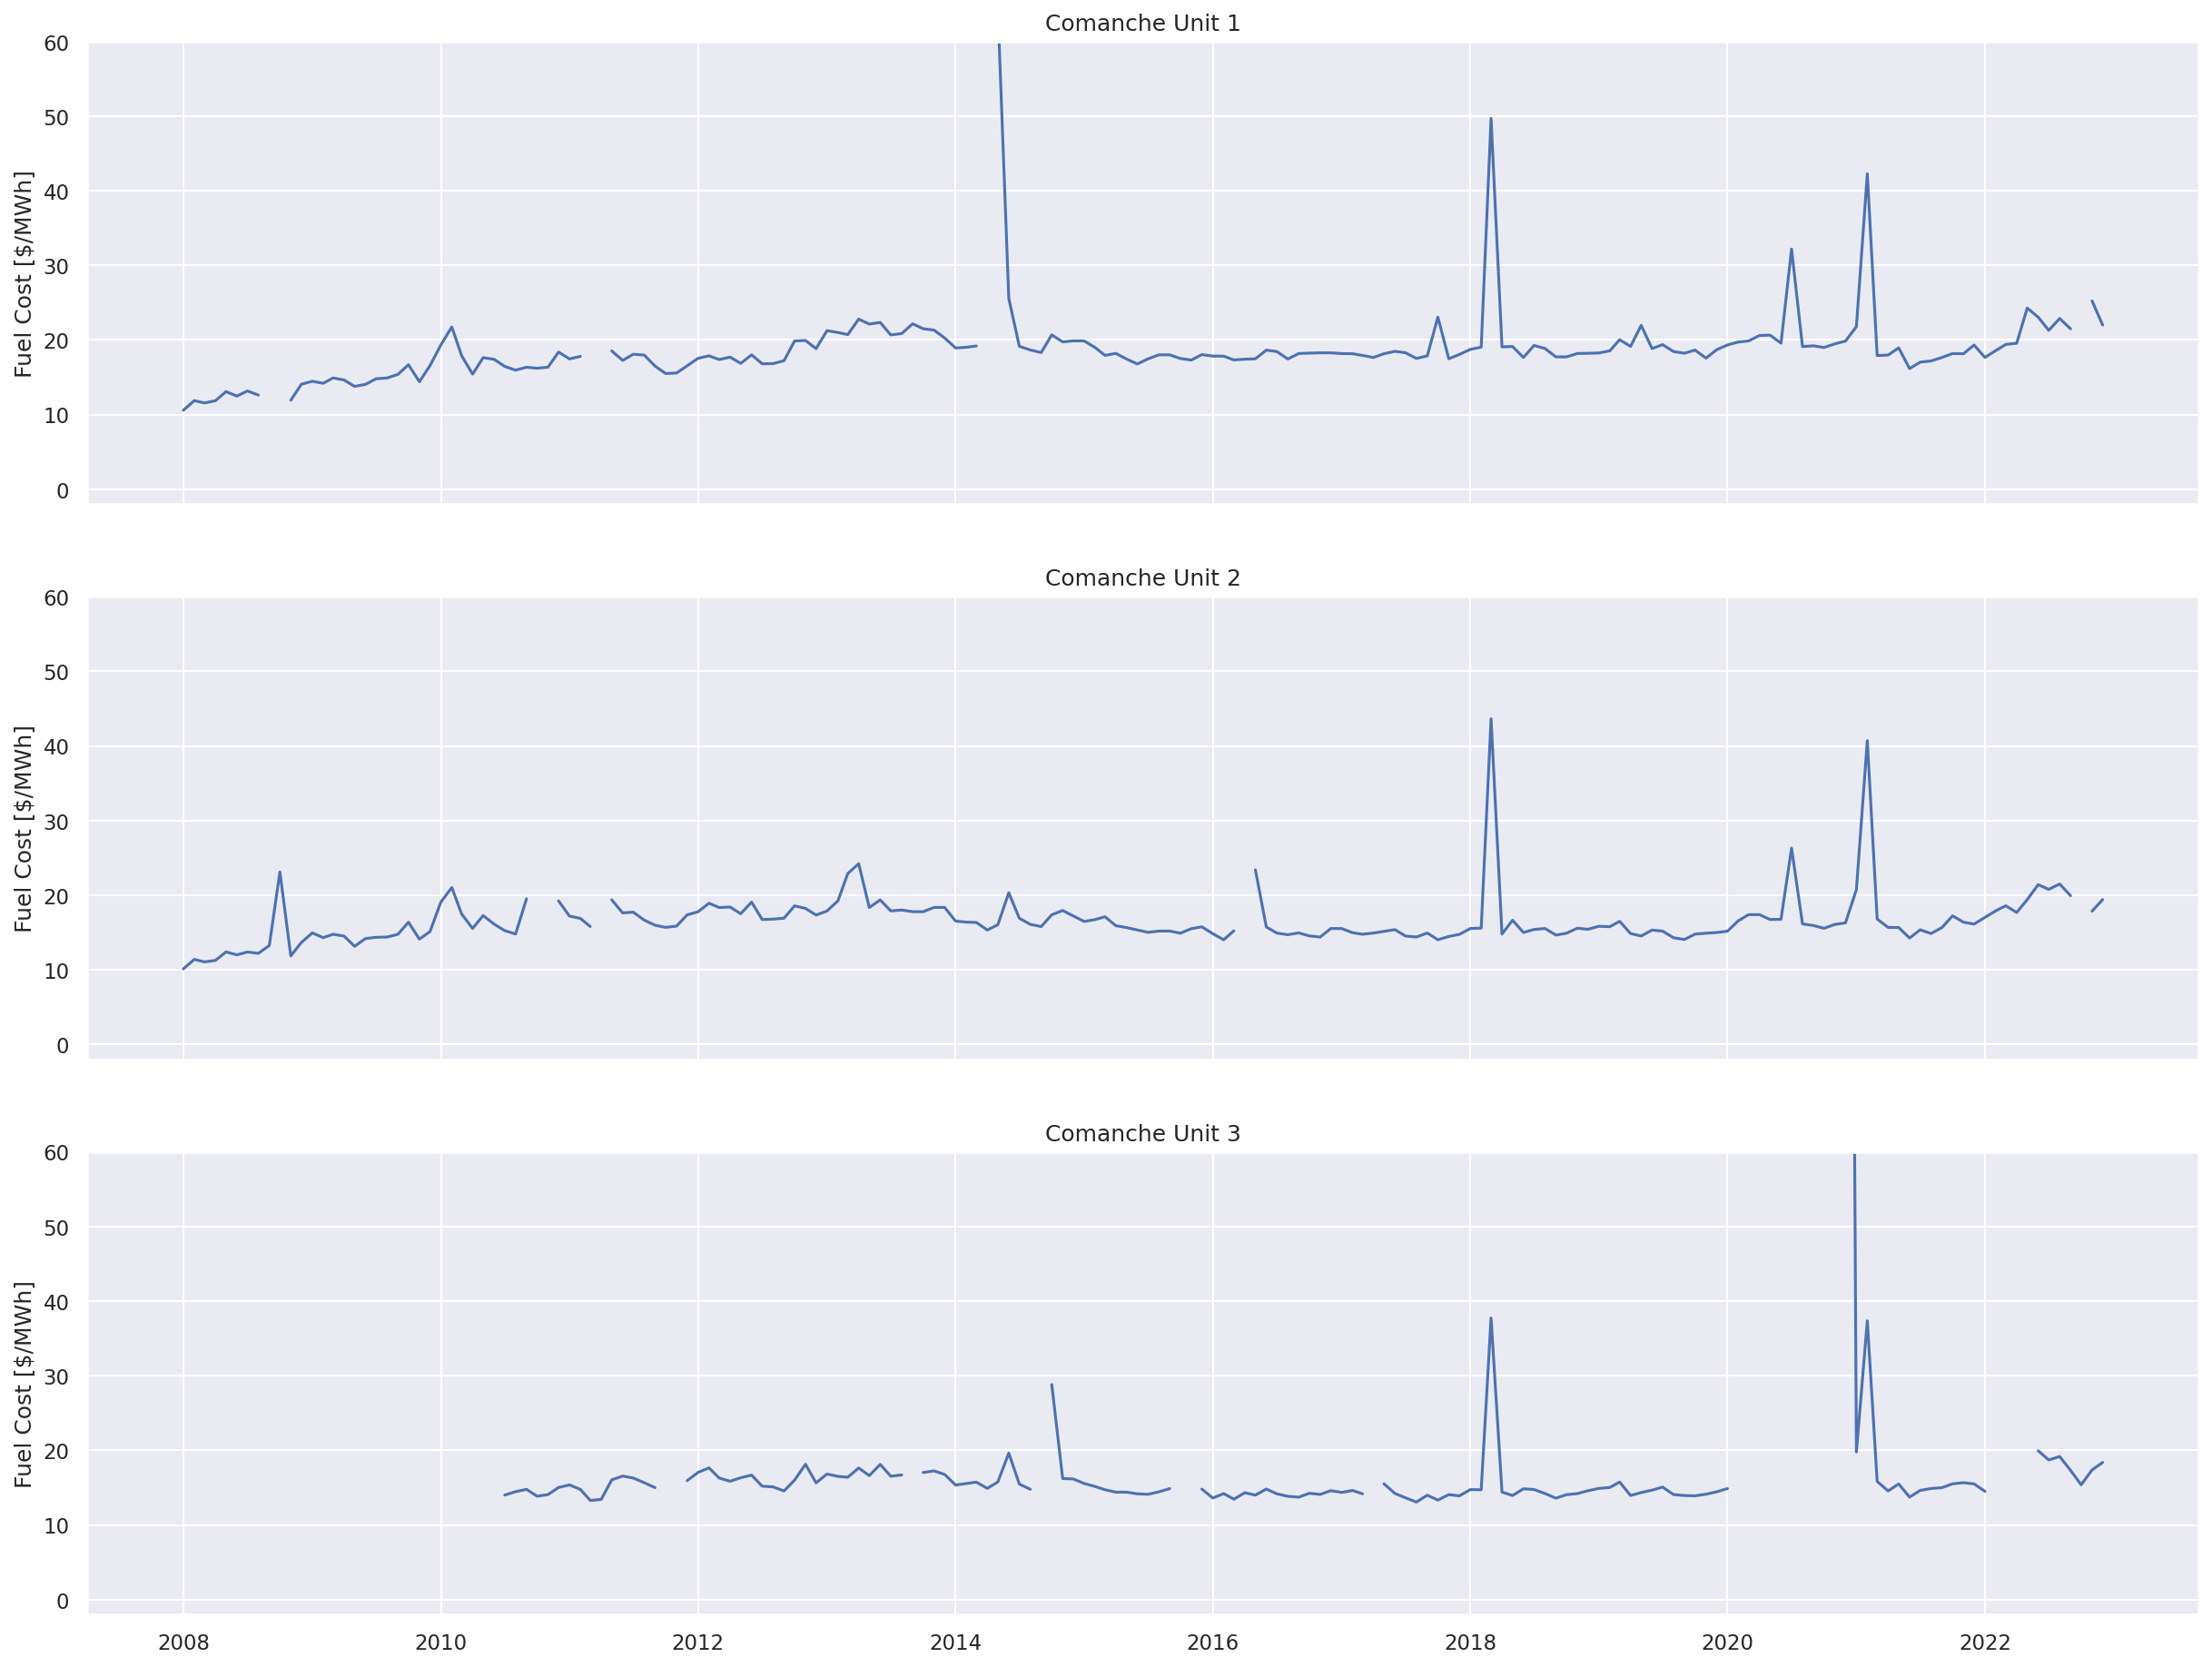

In [9]:
gen_ids = ["1", "2", "3"]
fig, axs = plt.subplots(nrows=len(gen_ids), ncols=1, sharex=True, figsize=(20,15))
for n, gen_id in enumerate(gen_ids):
    axs[n].plot(
        pd.to_datetime(comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "report_date"]),
        comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "fuel_cost_per_mwh"],
    )
    axs[n].set_ylim(-2, 60)
    axs[n].set_title(f"Comanche Unit {gen_id}")
    axs[n].set_ylabel("Fuel Cost [$/MWh]")
plt.show();

## Monthly Average Heat Rates
- The higher estimated heat rate for Unit 1 is likely the cause of higher fuel cost estimates above.

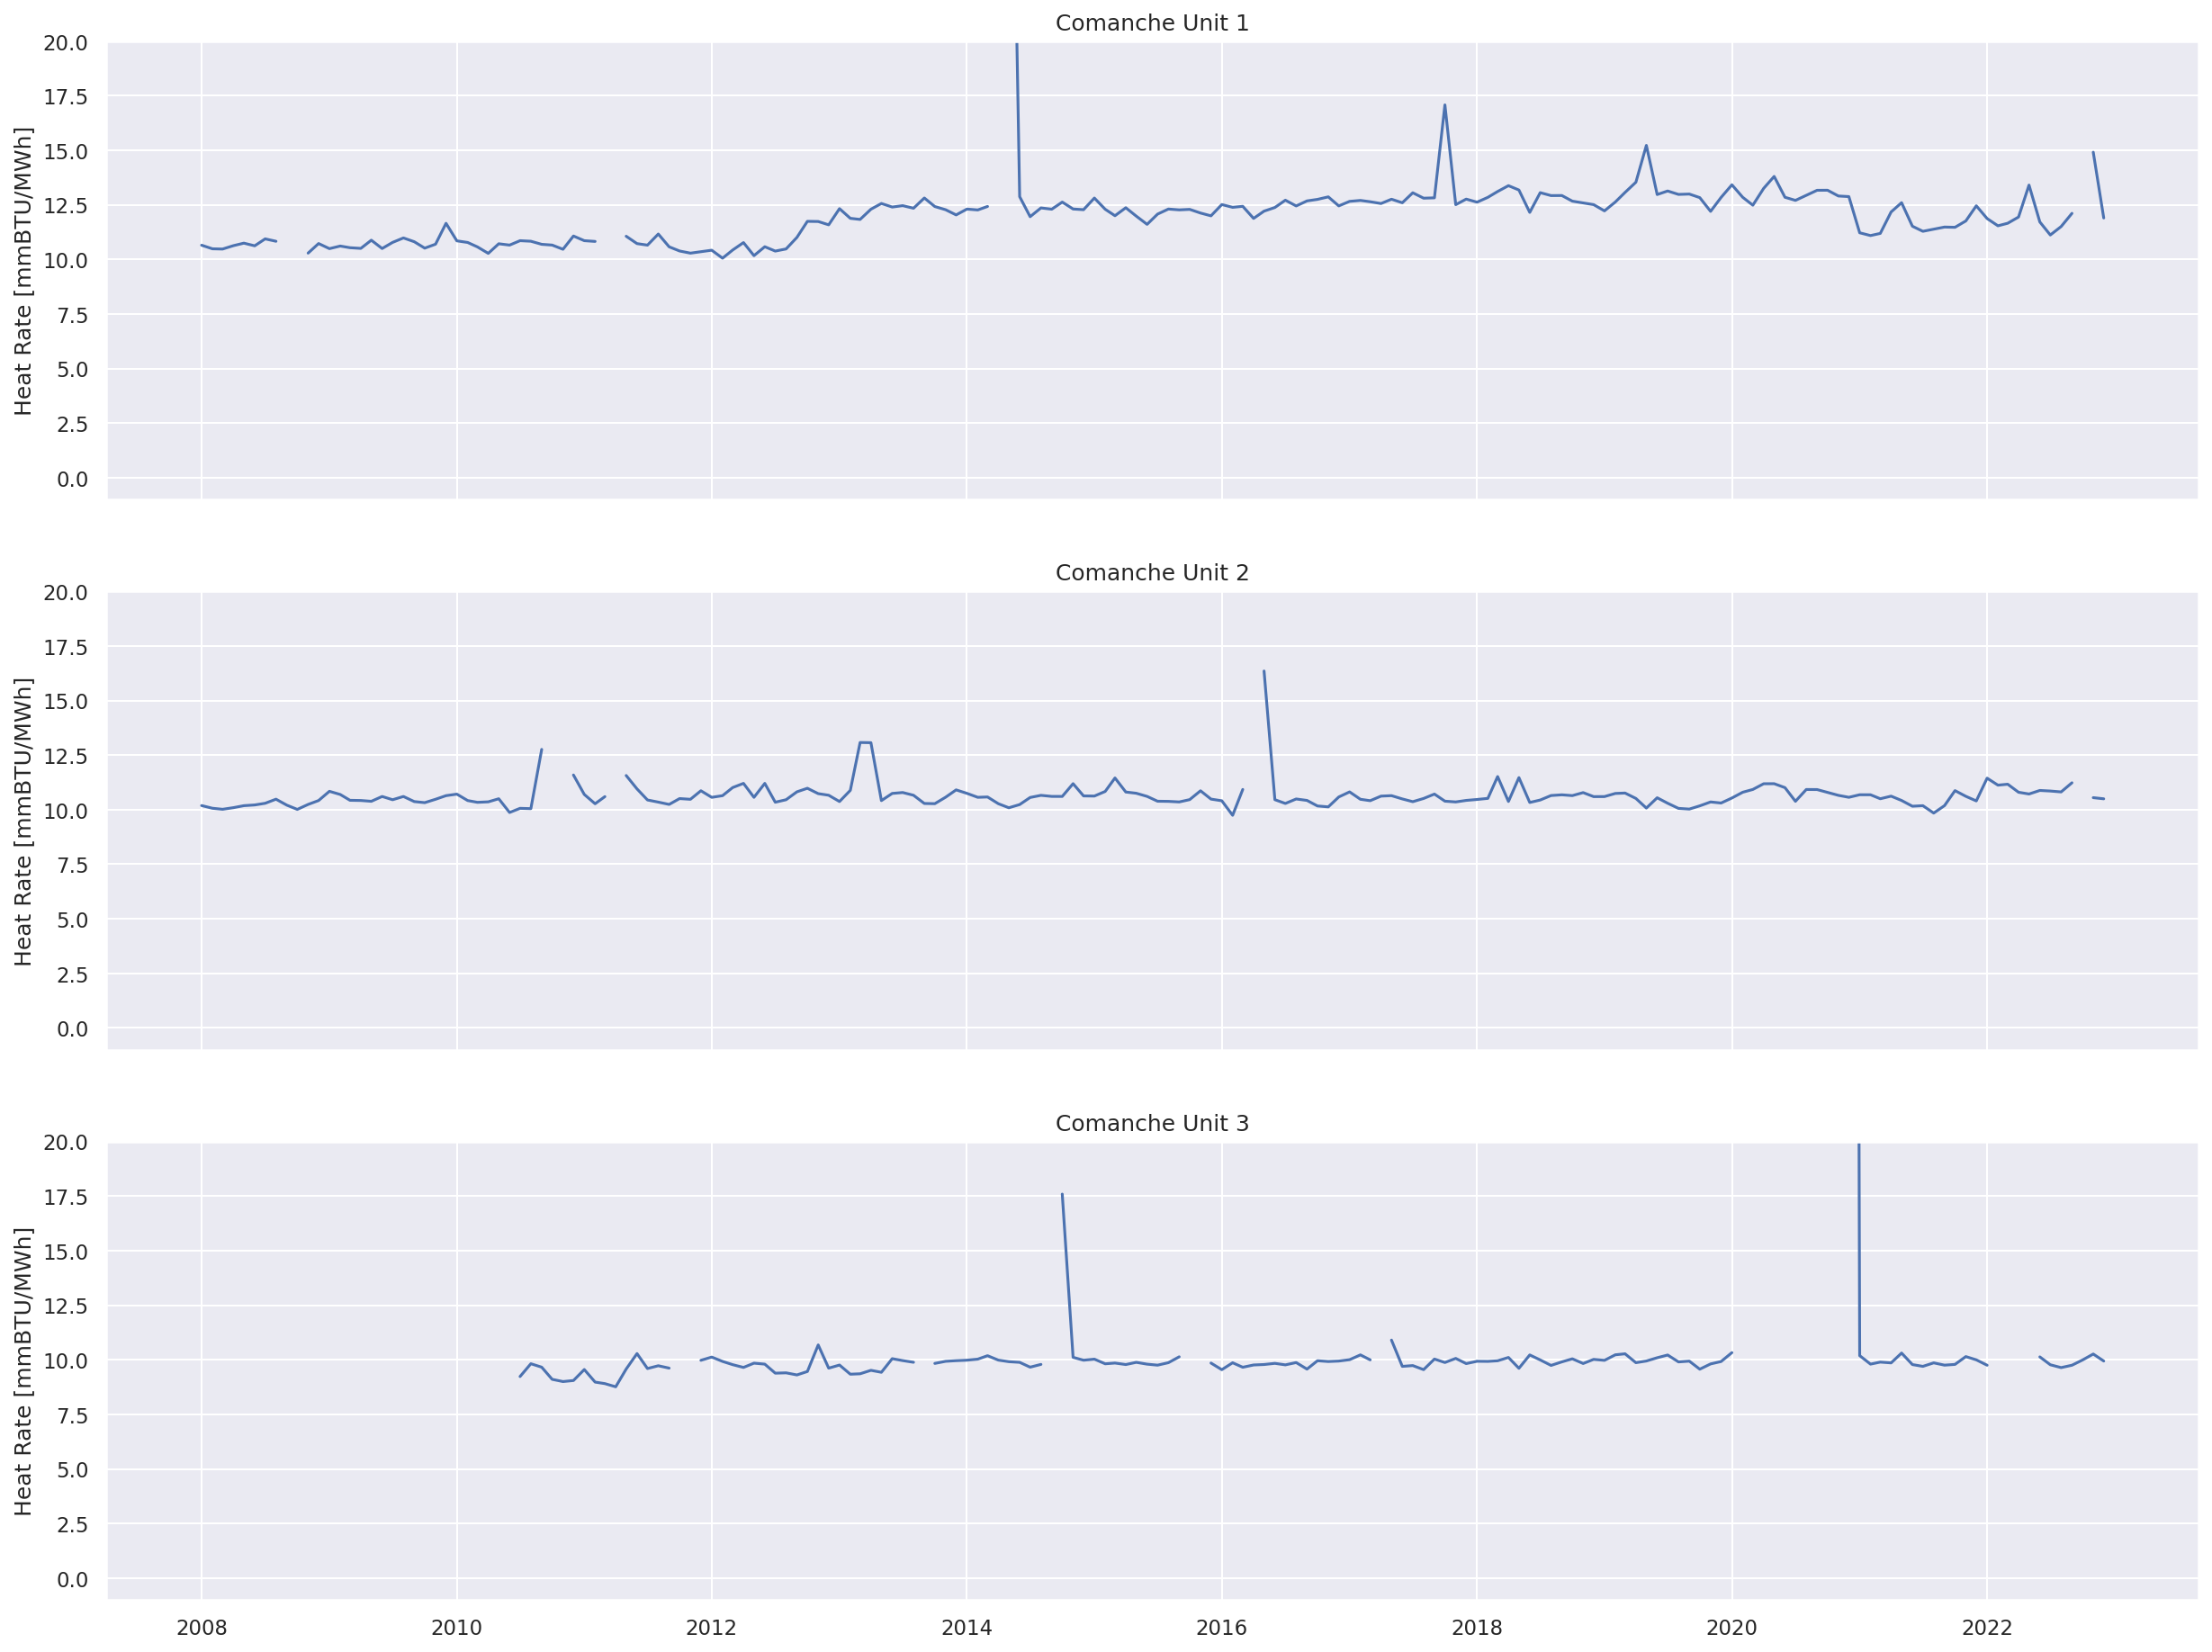

In [10]:
gen_ids = ["1", "2", "3"]
fig, axs = plt.subplots(nrows=len(gen_ids), ncols=1, sharex=True, figsize=(20,15))
for n, gen_id in enumerate(gen_ids):
    axs[n].plot(
        pd.to_datetime(comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "report_date"]),
        comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "heat_rate_mmbtu_mwh"],
    )
    axs[n].set_ylim(-1, 20)
    axs[n].set_title(f"Comanche Unit {gen_id}")
    axs[n].set_ylabel("Heat Rate [mmBTU/MWh]")
plt.show();

## Monthly Capacity Factor

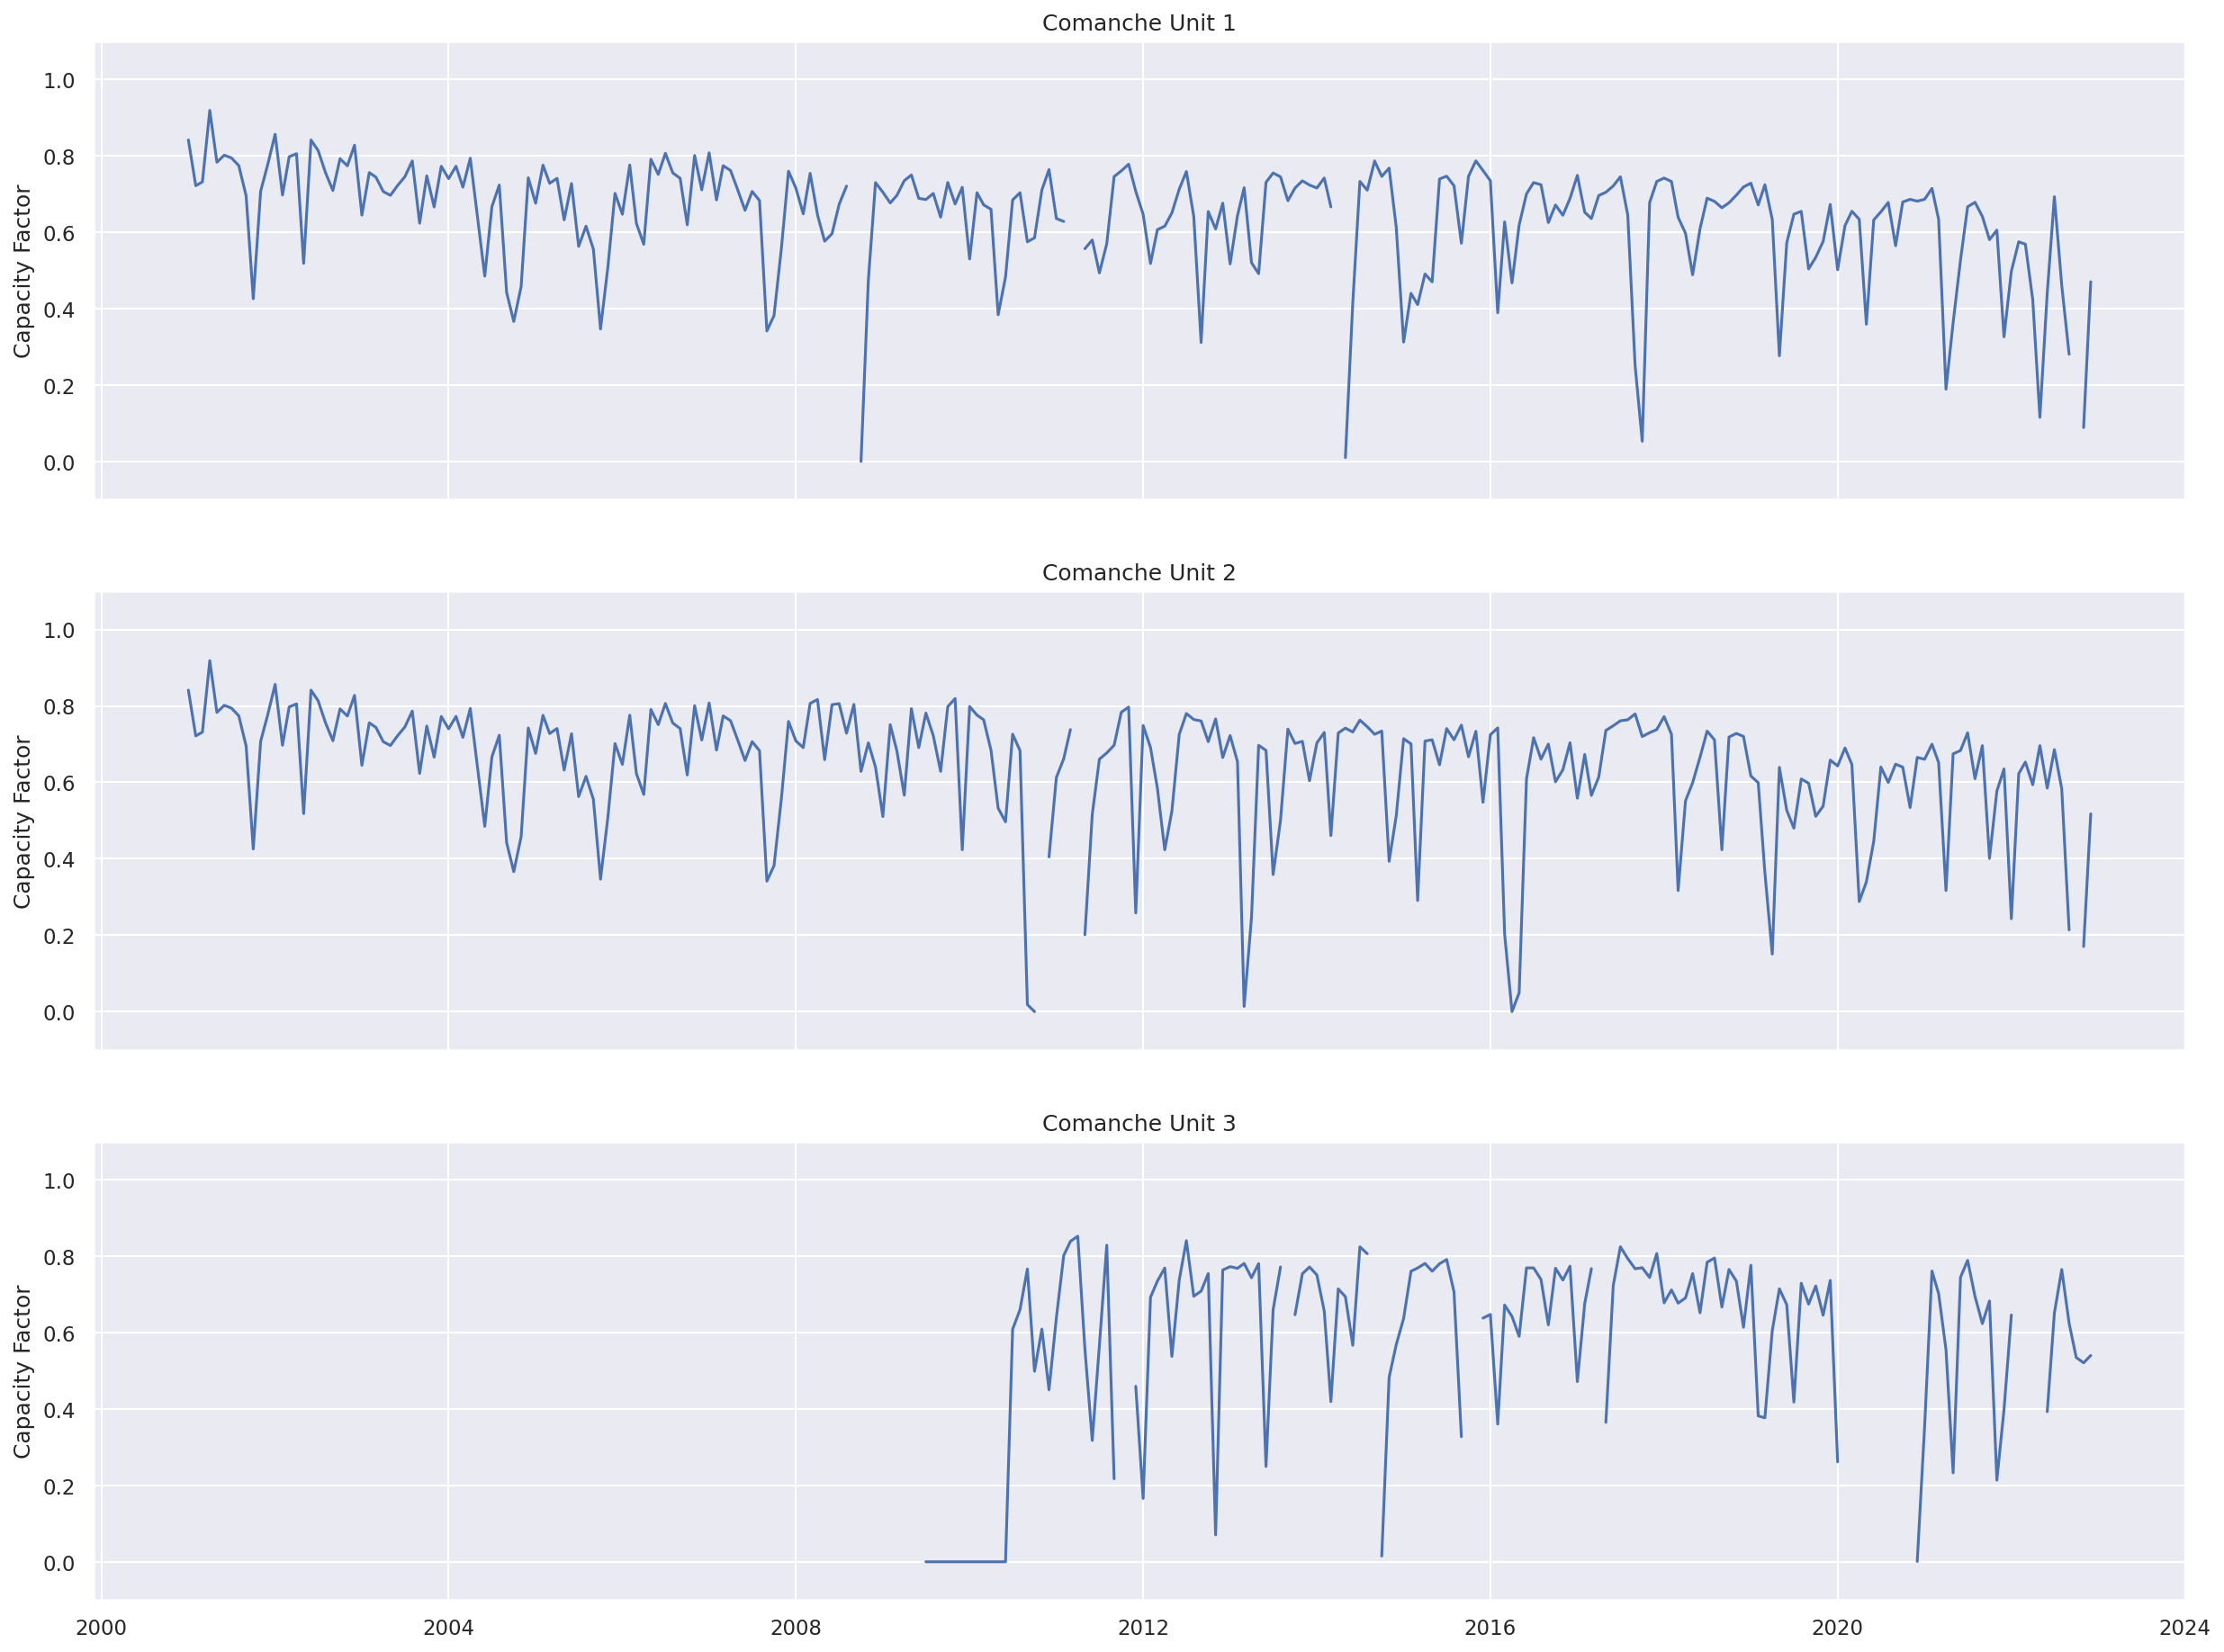

In [11]:
gen_ids = ["1", "2", "3"]
fig, axs = plt.subplots(nrows=len(gen_ids), ncols=1, sharex=True, figsize=(20,15))
for n, gen_id in enumerate(gen_ids):
    axs[n].plot(
        pd.to_datetime(comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "report_date"]),
        comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "capacity_factor"],
    )
    axs[n].set_ylim(-0.1, 1.1)
    axs[n].set_title(f"Comanche Unit {gen_id}")
    axs[n].set_ylabel("Capacity Factor")
plt.show();

In [12]:
comanche_mcoe[comanche_mcoe.generator_id=="3"]

plant_id_eia generator_id report_date  unit_id_pudl  plant_id_pudl  \
687           470            3  2005-01-01          <NA>            126   
688           470            3  2006-01-01          <NA>            126   
689           470            3  2007-01-01          <NA>            126   
690           470            3  2008-01-01          <NA>            126   
360           470            3  2009-07-01             3            126   
..            ...          ...         ...           ...            ...   
513           470            3  2022-09-01             3            126   
514           470            3  2022-10-01             3            126   
515           470            3  2022-11-01             3            126   
516           470            3  2022-12-01             3            126   
691           470            3  2023-01-01          <NA>            126   

    plant_name_eia  utility_id_eia  utility_id_pudl  \
687       Comanche           15466              272   
688       Comanche           15466              272   
689       Comanche           15466              272   
690       Comanche           15466              272   
360       Comanche           15466              272   
..             ...             ...              ...   
513       Comanche           15466              272   
514       Comanche           15466              272   
515       Comanche           15466              272   
516       Comanche           15466              272   
691       Comanche           15466              272   

                  utility_name_eia   technology_description  \
687  Public Service Co of Colorado  Conventional Steam Coal   
688  Public Service Co of Colorado  Conventional Steam Coal   
689  Public Service Co of Colorado  Conventional Steam Coal   
690  Public Service Co of Colorado  Conventional Steam Coal   
360  Public Service Co of Colorado  Conventional Steam Coal   
..                             ...                      ...   
513  Public Service Co of Colorado  Conventional Steam Coal   
514  Public Service Co of Colorado  Conventional Steam Coal   
515  Public Service Co of Colorado  Conventional Steam Coal   
516  Public Service Co of Colorado  Conventional Steam Coal   
691  Public Service Co of Colorado  Conventional Steam Coal   

    energy_source_code_1 prime_mover_code generator_operating_date  \
687                  SUB               ST               2010-07-01   
688                  SUB               ST               2010-07-01   
689                  SUB               ST               2010-07-01   
690                  SUB               ST               2010-07-01   
360                  SUB               ST               2010-07-01   
..                   ...              ...                      ...   
513                  SUB               ST               2010-07-01   
514                  SUB               ST               2010-07-01   
515                  SUB               ST               2010-07-01   
516                  SUB               ST               2010-07-01   
691                  SUB               ST               2010-07-01   

    generator_retirement_date operational_status  capacity_mw  \
687                      <NA>           proposed        820.0   
688                      <NA>           proposed        820.0   
689                      <NA>           proposed        820.0   
690                      <NA>           proposed        856.8   
360                      <NA>           proposed        856.8   
..                        ...                ...          ...   
513                      <NA>           existing        856.8   
514                      <NA>           existing        856.8   
515                      <NA>           existing        856.8   
516                      <NA>           existing        856.8   
691                      <NA>           existing        856.8   

    fuel_type_code_pudl planned_generator_retirement_date  capac

# Read Hourly Generation & Emissions Data from Apache Parquet
* The full hourly emissions time series for thousands of US power plants covering 1995-2022 contains almost a billion records.
* The data is stored in a single [Apache Parquet file](https://parquet.apache.org/) with row-groups defined by year and state.
* This compressed columnar format enables very efficient queries with appropriate tooling, including [Dask](https://www.dask.org/) and [PyArrow](https://arrow.apache.org/docs/python/index.html).
* Reading the entire dataset into memory at once will probably exceed the available RAM.
* Other tools like [DuckDB](https://duckdb.org/docs/data/parquet/overview.html) ([Python API](https://duckdb.org/docs/api/python/overview)) also provide good Parquet support. 

In [13]:
%%time
from dask import dataframe as dd

unit_ids = ["1", "2", "3"]
cems_cols = [
    "operating_datetime_utc",
    "plant_id_eia",
    "plant_id_epa",
    "emissions_unit_id_epa",
    "operating_time_hours",
    "gross_load_mw",
    "heat_content_mmbtu",
    "co2_mass_tons",
]

## dd is dask.dataframe
comanche_cems_dd = dd.read_parquet(
    f"{pudl_path}/hourly_emissions_epacems.parquet",
    engine="pyarrow",
    filters=[
        ("state", "=", "CO"),
        ("plant_id_eia", "=", 470),
    ],
    columns=cems_cols,
    index=False,
)
comanche_cems = (
    comanche_cems_dd.compute()
    .assign(
        gross_generation_mwh=lambda x: x.operating_time_hours * x.gross_load_mw,
        heat_rate_mmbtu_per_mwh=lambda x: x.heat_content_mmbtu / x.gross_generation_mwh,
        gross_co2_intensity=lambda x: x.co2_mass_tons / x.gross_generation_mwh
    )
)
comanche_cems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569760 entries, 0 to 569759
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   operating_datetime_utc   569760 non-null  datetime64[ns, UTC]
 1   plant_id_eia             569760 non-null  int32              
 2   plant_id_epa             569760 non-null  int32              
 3   emissions_unit_id_epa    569760 non-null  object             
 4   operating_time_hours     569476 non-null  float32            
 5   gross_load_mw            483648 non-null  float32            
 6   heat_content_mmbtu       483648 non-null  float32            
 7   co2_mass_tons            483648 non-null  float32            
 8   gross_generation_mwh     483648 non-null  float32            
 9   heat_rate_mmbtu_per_mwh  483636 non-null  float32            
 10  gross_co2_intensity      483576 non-null  float32            
dtypes: datetime64

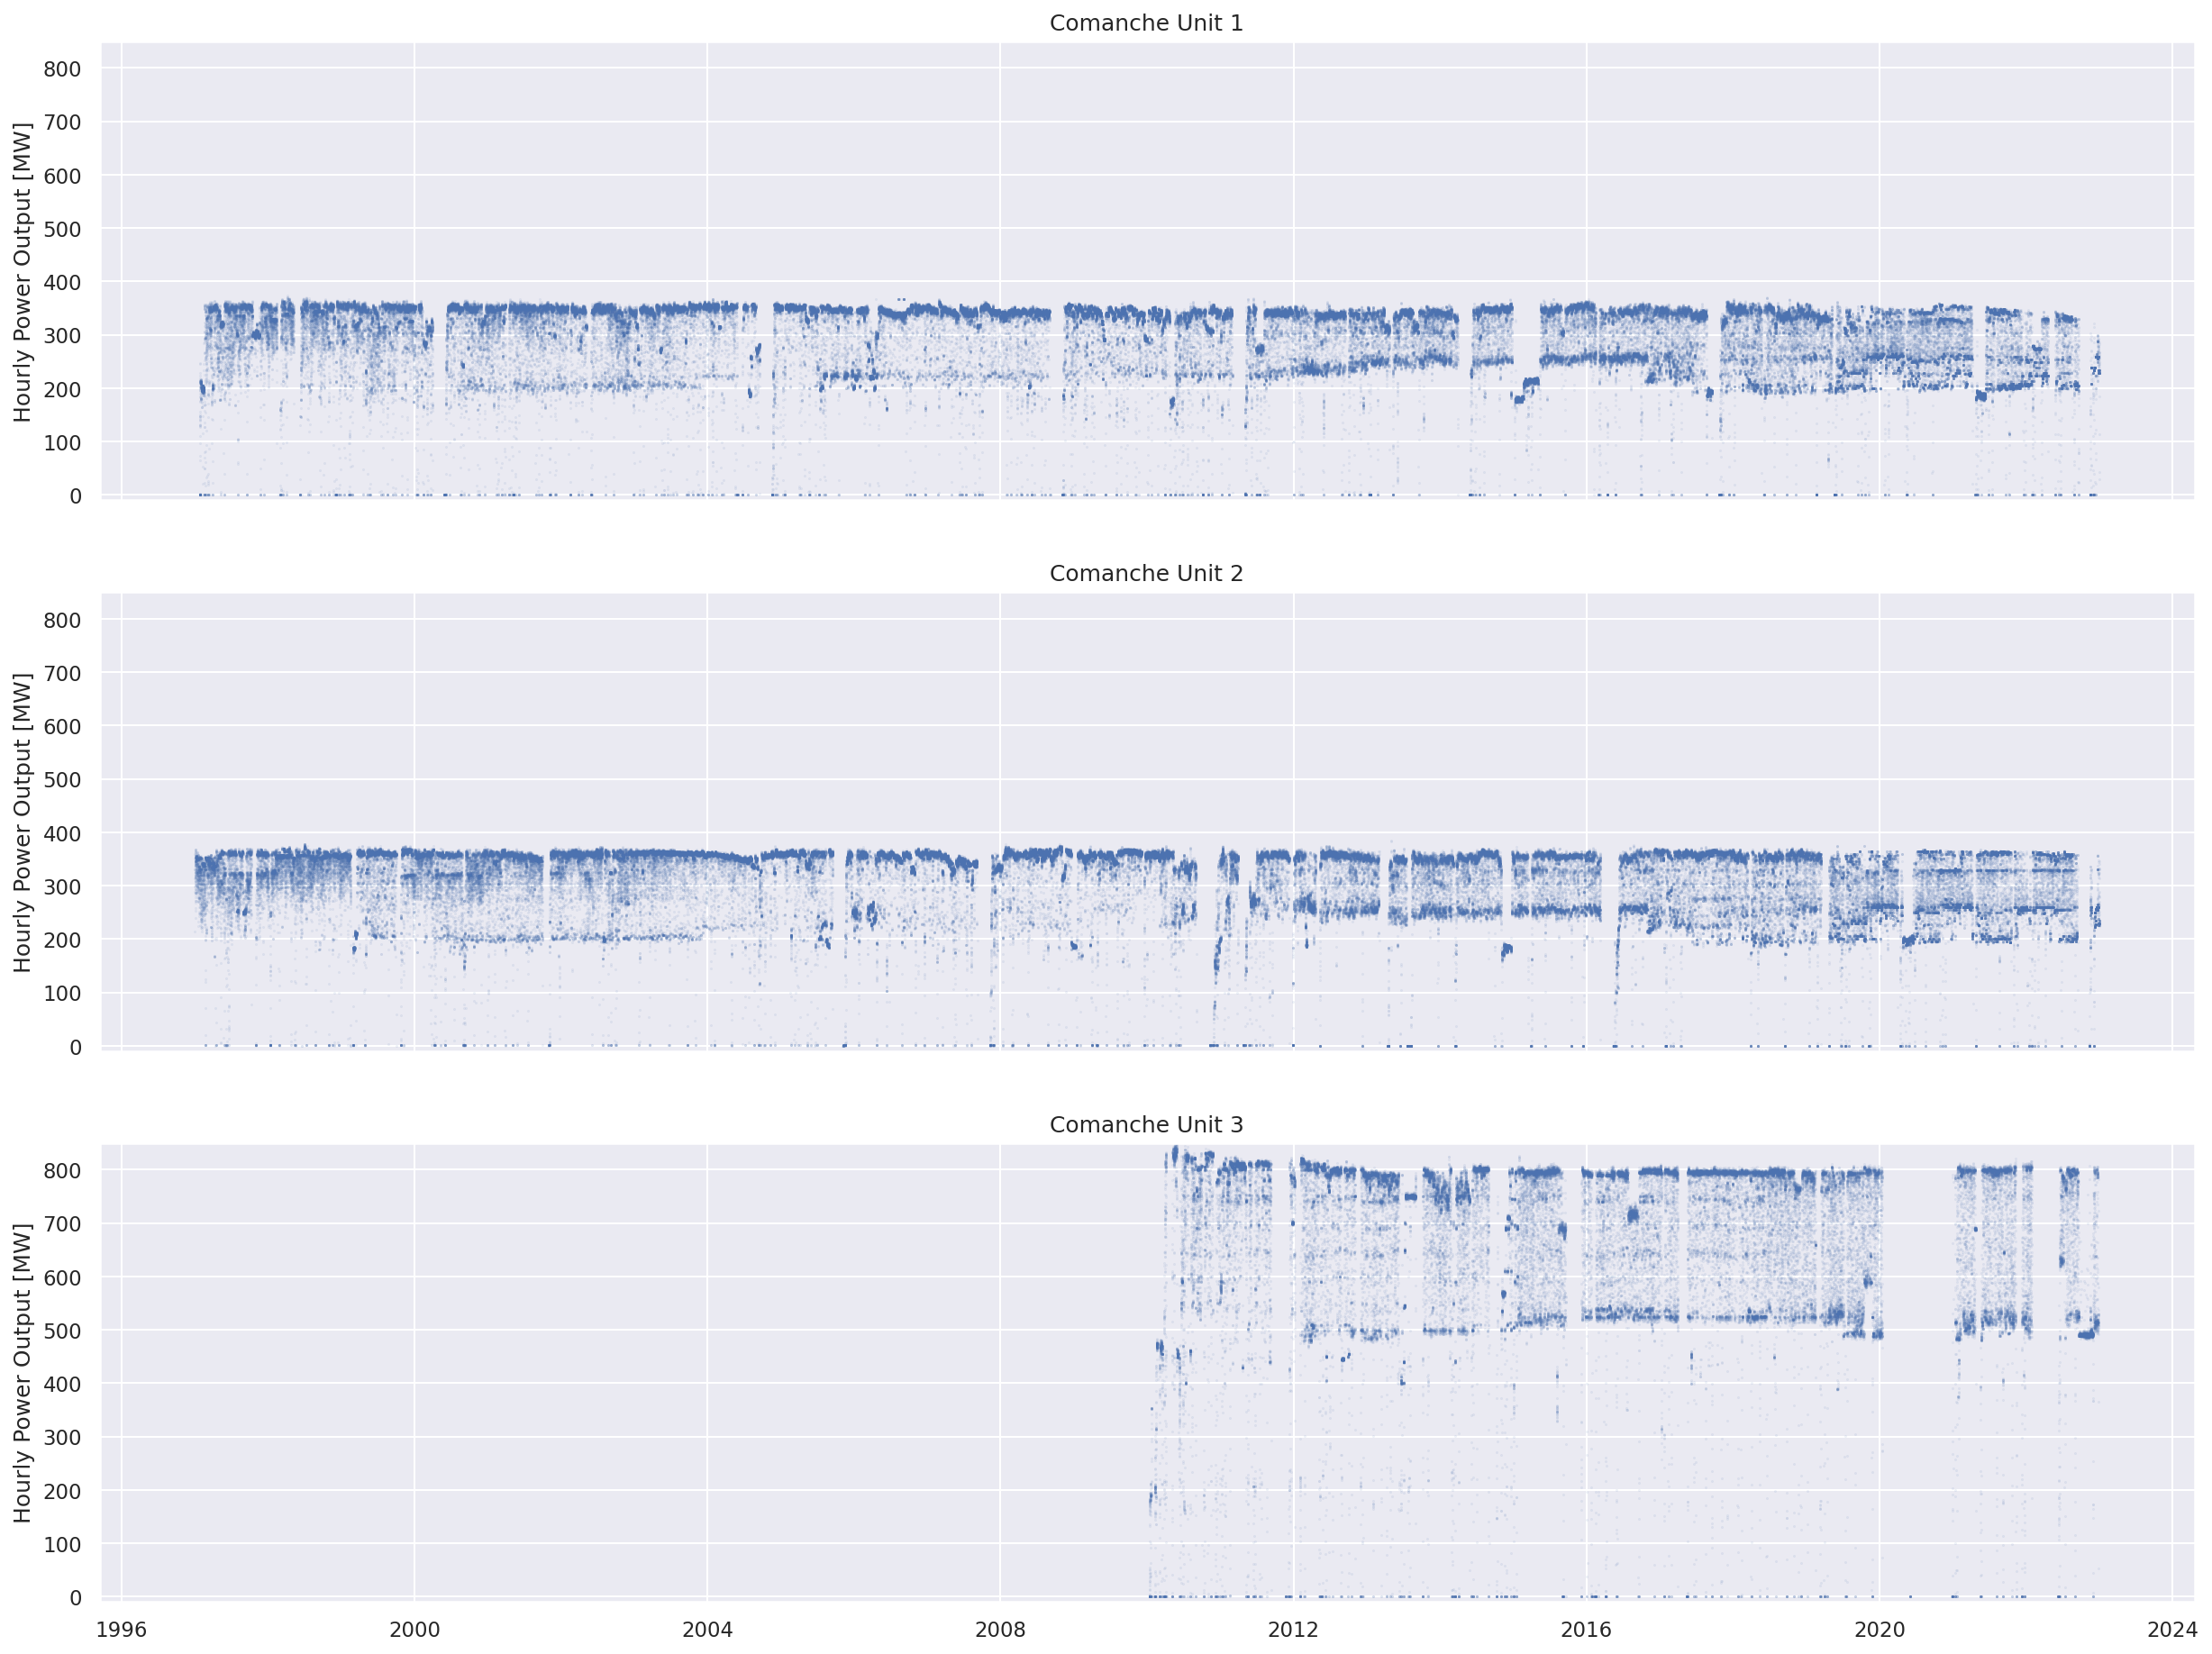

In [14]:
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unit_id in enumerate(unit_ids):
    axs[n].scatter(
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "operating_datetime_utc"],
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "gross_generation_mwh"],
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-10, 850)
    axs[n].set_title(f"Comanche Unit {unit_id}")
    axs[n].set_ylabel("Hourly Power Output [MW]")
plt.show();

## Fuel Consumption

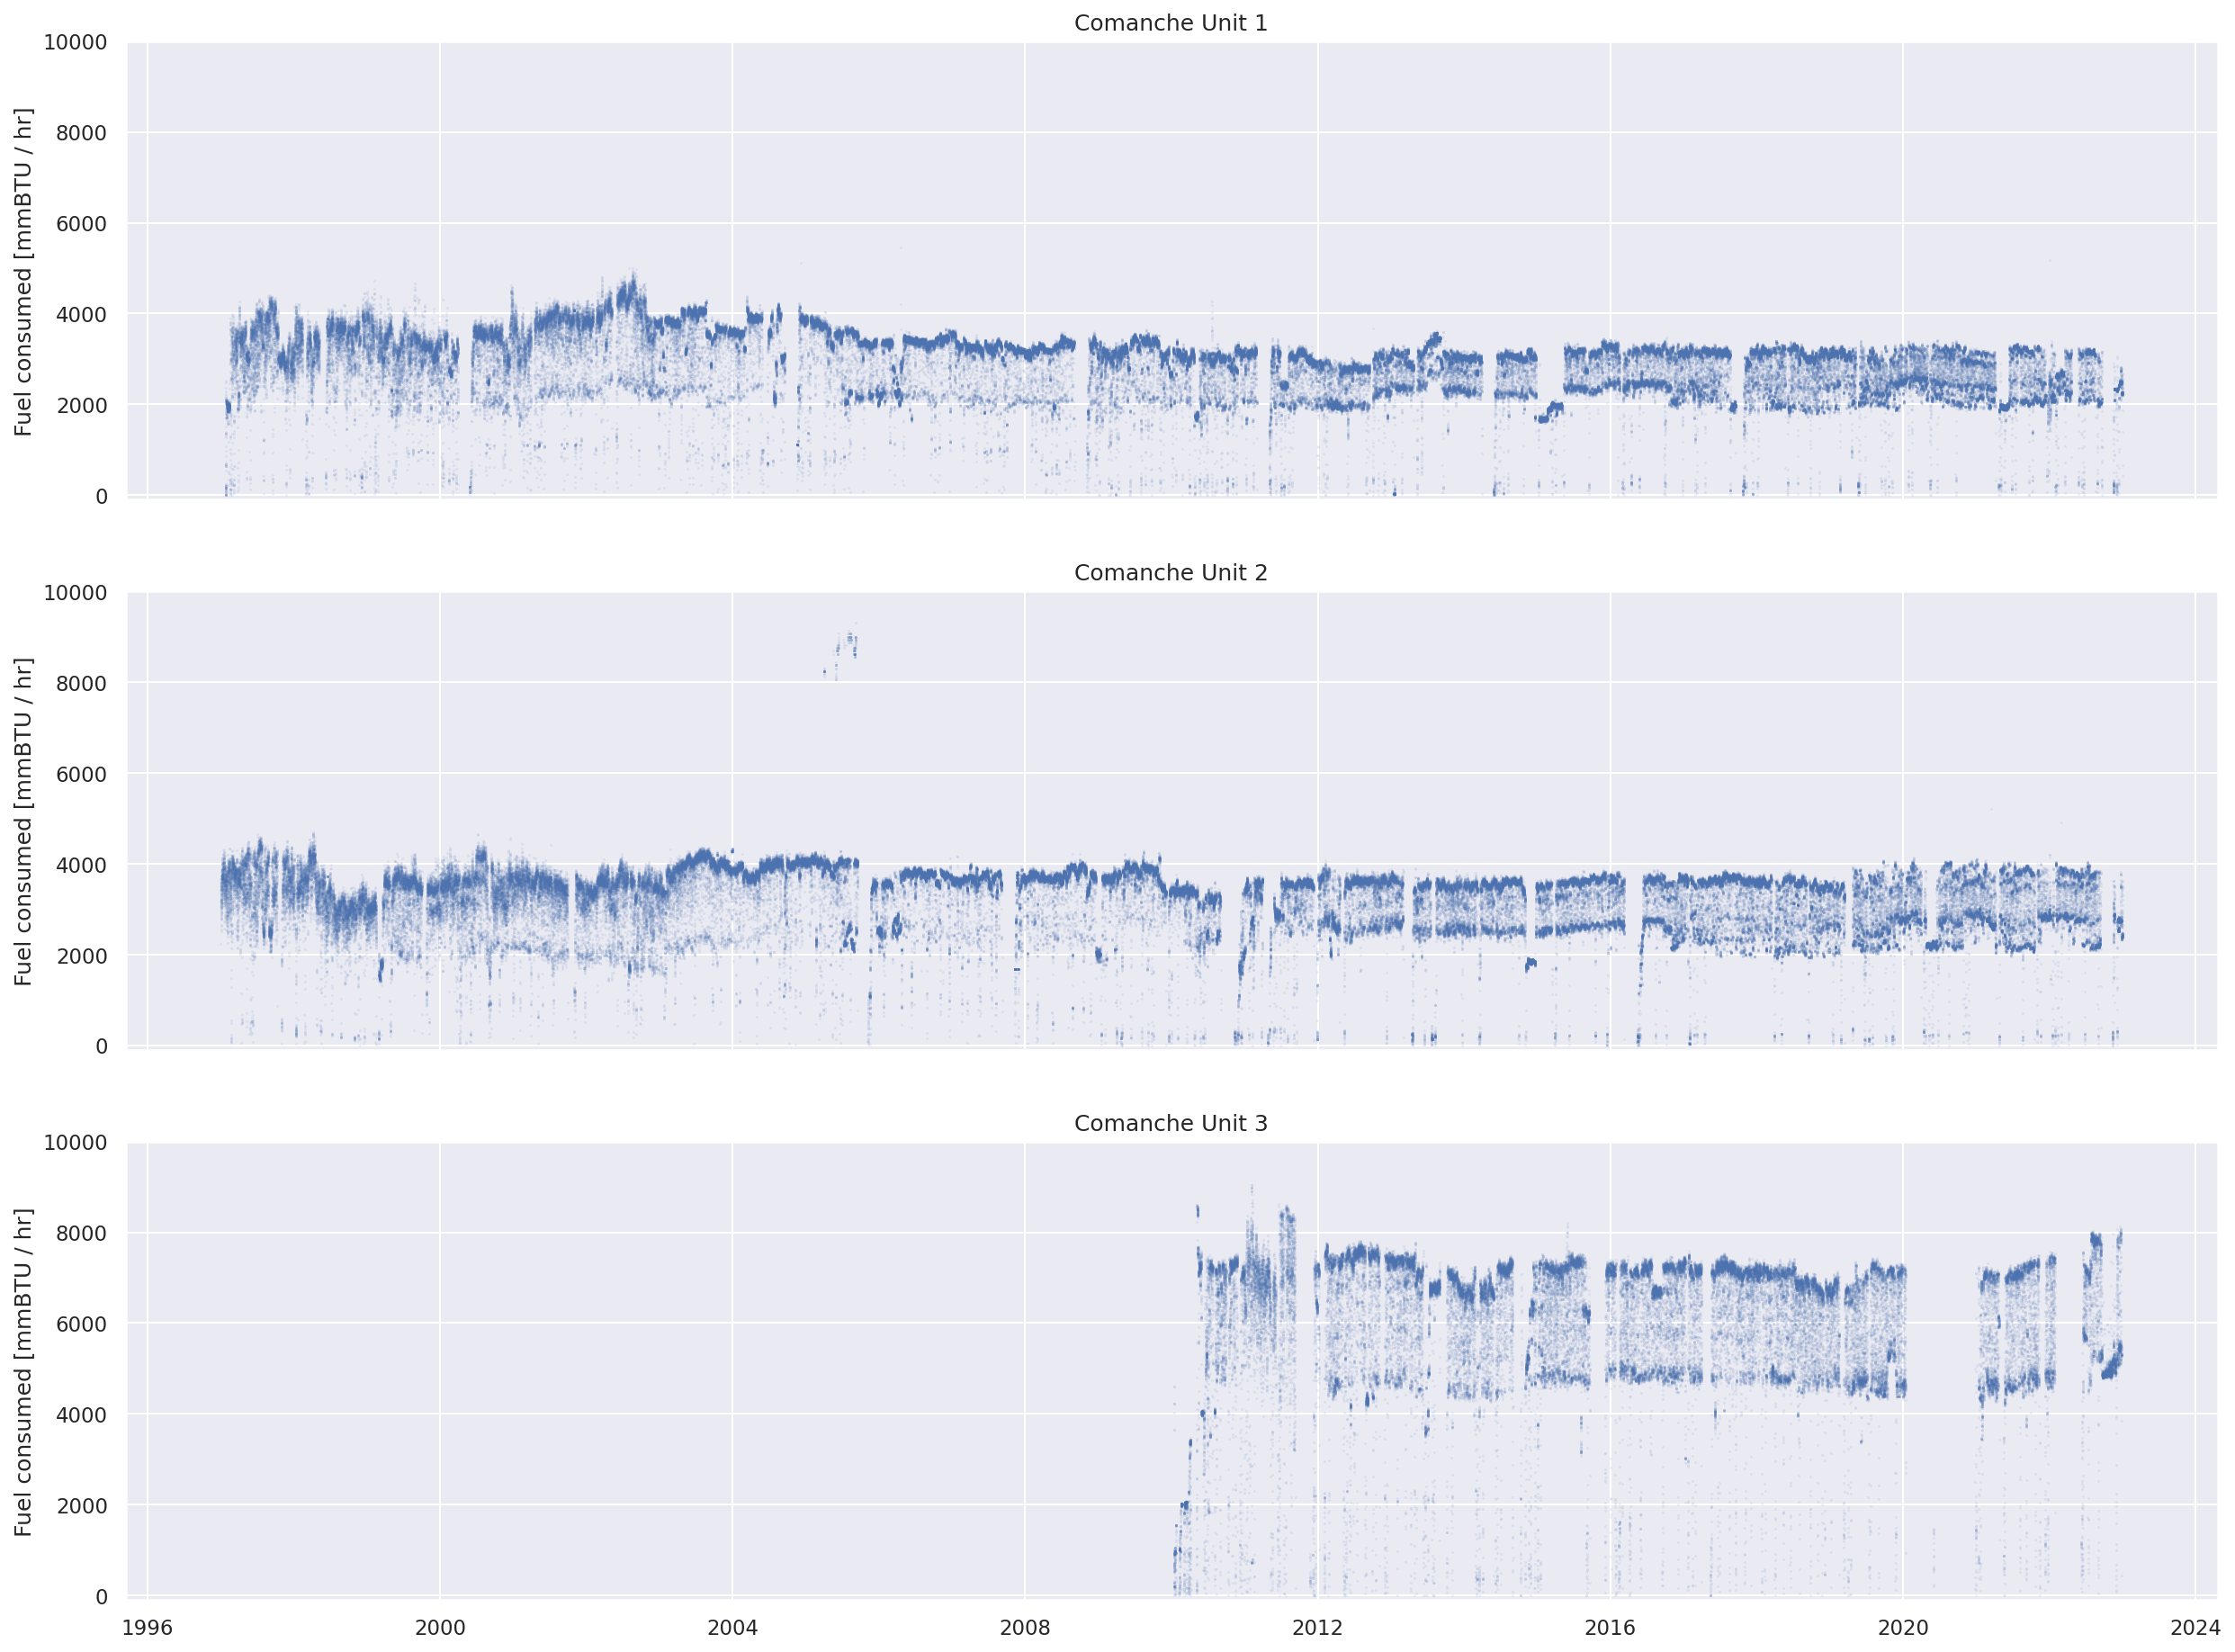

In [15]:
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unit_id in enumerate(unit_ids):
    axs[n].scatter(
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "operating_datetime_utc"],
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "heat_content_mmbtu"],
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-100,10_000)
    axs[n].set_title(f"Comanche Unit {unit_id}")
    axs[n].set_ylabel("Fuel consumed [mmBTU / hr]")
plt.show();

## Heat Rates

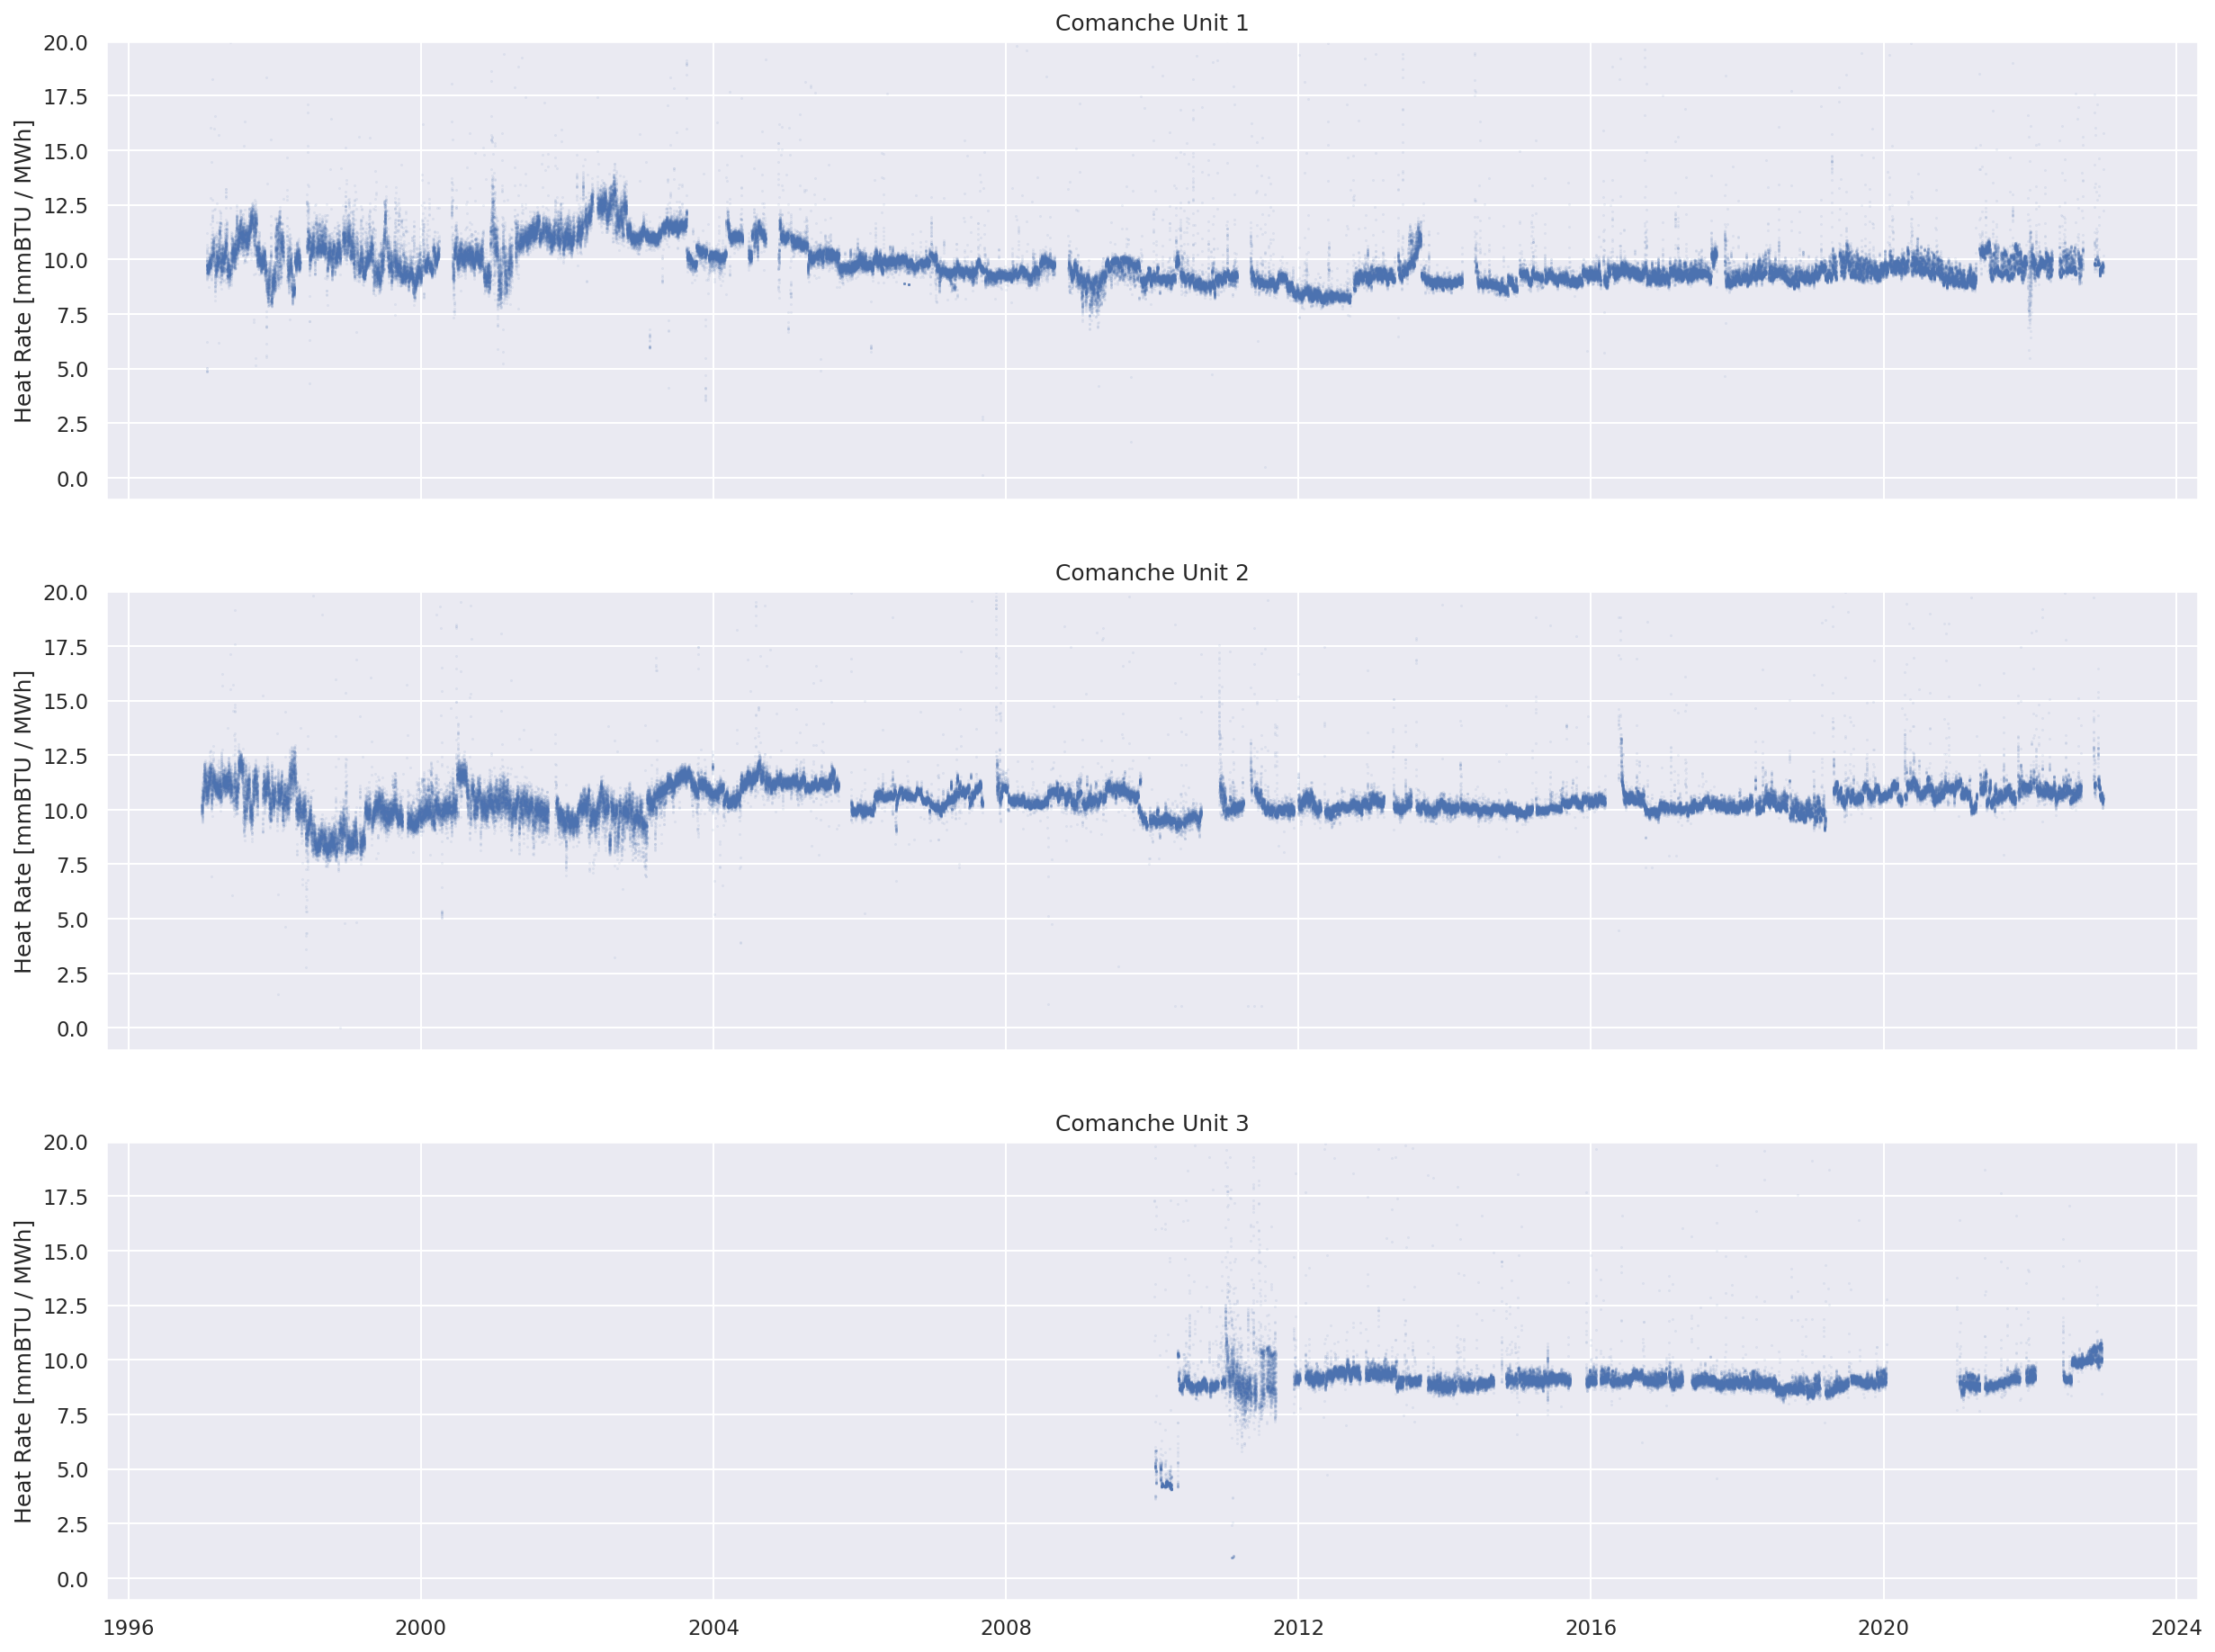

In [16]:
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unit_id in enumerate(unit_ids):
    axs[n].scatter(
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "operating_datetime_utc"],
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "heat_rate_mmbtu_per_mwh"],
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-1,20)
    axs[n].set_title(f"Comanche Unit {unit_id}")
    axs[n].set_ylabel("Heat Rate [mmBTU / MWh]")
plt.show();

## Emissions Intensity

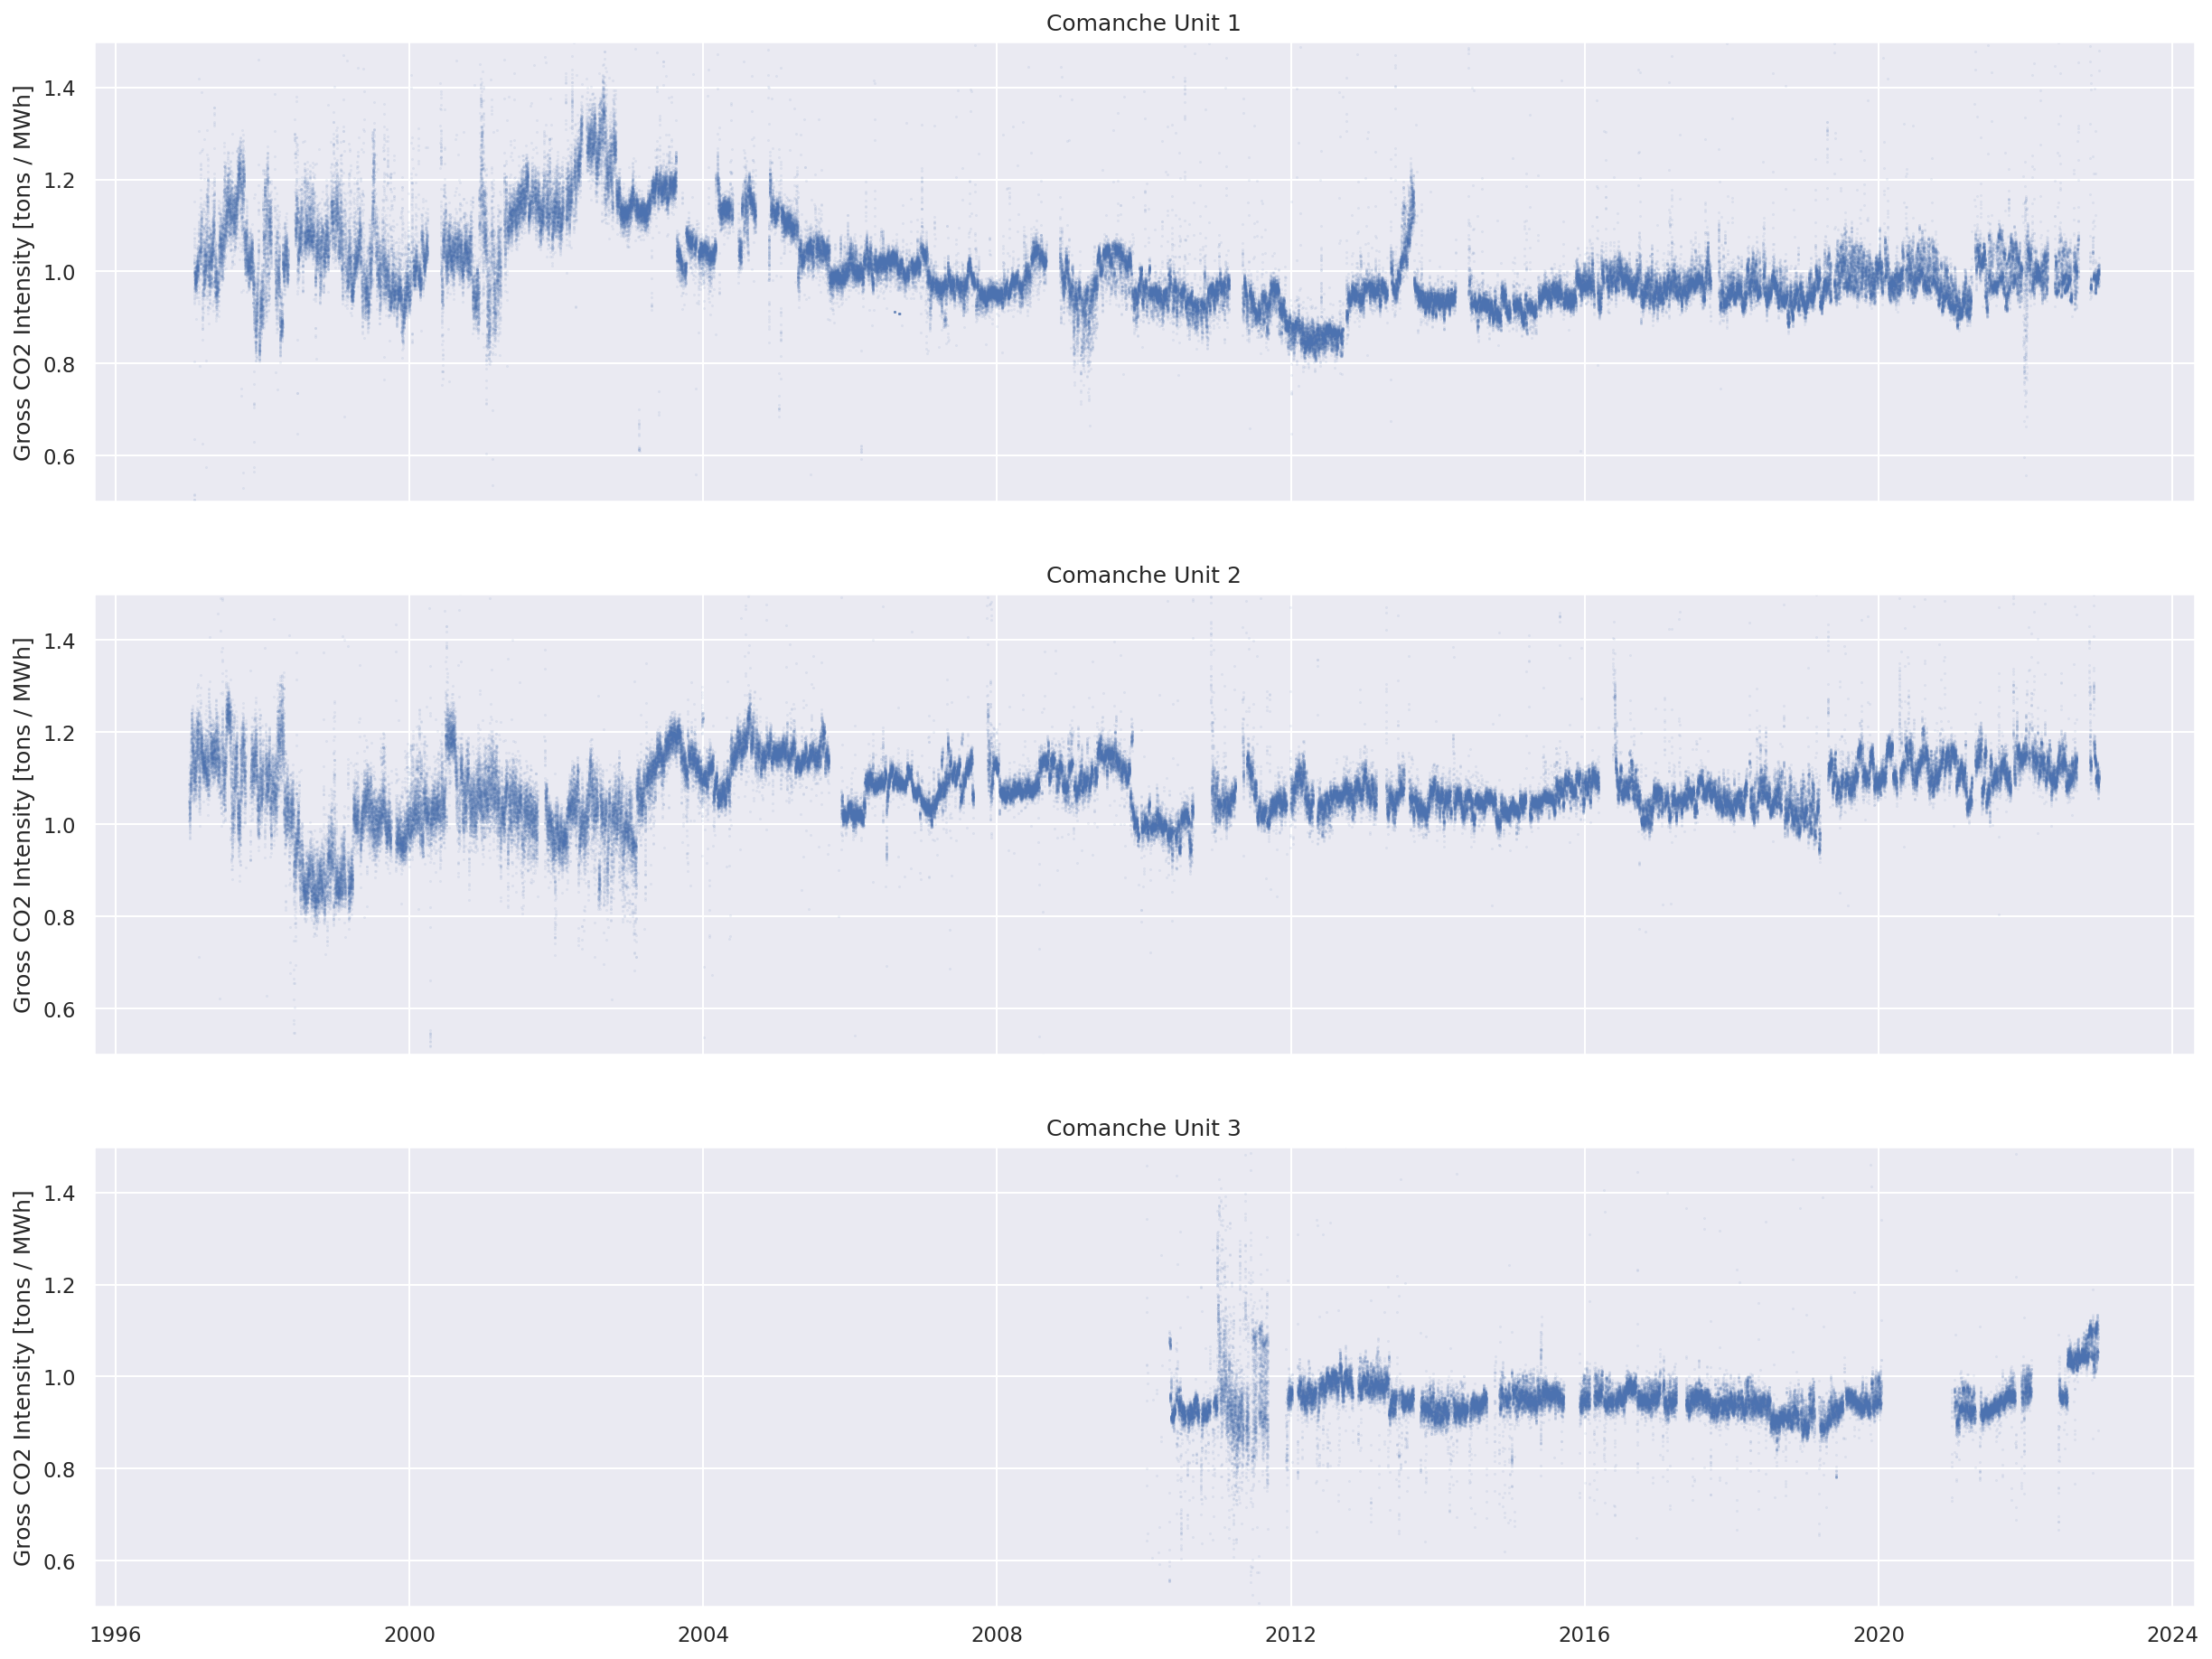

In [17]:
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unit_id in enumerate(unit_ids):
    axs[n].scatter(
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "operating_datetime_utc"],
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "gross_co2_intensity"],
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(0.5,1.5)
    axs[n].set_title(f"Comanche Unit {unit_id}")
    axs[n].set_ylabel("Gross CO2 Intensity [tons / MWh]")
plt.show();